Tutorials for course ECE1508 Reinforcement Learning at the University of Toronto.

Author: Xiaocan (Bruce) Li

Email: hsiaotsan.li@mail.utoronto.ca

#Recap of last tutorial
In the previous tutorial, we covered how to use tabular RL for continuous state problems with state discretization.

There is an impossible trinity of Tabular RL for Discretized States:
1. Better performance;
2. Fewer training episodes;
3. Finer discretization granularity.

Thanks to function approximations, we can remove the third bullet point, and function approximations (with DQN) will be covered in this tutorial.

#Overview


In this tutorial, we are going to solve Mountain Car game that has a continuous state space, and a discrete action space.

**About The Mountain Car**:

It's MDP is a deterministic MDP that consists of a car placed randomly at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to accelerate the car to reach the goal state on top of the right hill.

Two ways to deal with the continuous state space:
1. **Discretization [June 26]**: Uniformly cut each state variable into bins, and then solve it with **Tabular RL**, e.g., Q-learning, SARSA.
2. **Function Approximations with DQN [July 3]**: To represent the Q-function, we replace the Q-table, which traditionally maps state-action pairs to values, with a Deep Neural Network. Instead of storing and updating a table of Q-values, we maintain a set of model weights. These weights are used together with features derived from the state-action pairs to estimate Q-values.



**Space Complexity of Discretization:**

For the Mountain Car, the original state is 2D: [position, velocity].

Discretize each state variable into $b$ bins resulting in $b^2$ possible combination of discretized state variables.

**Quiz**:

What is the space complexity if we have $|S|$ state variables and $b$ bins for each state variable? If we double $b$, how many extra spaces are needed?


**Related links:**
* Mountain Car Official Website: https://www.gymlibrary.dev/environments/classic_control/mountain_car/
* Mountain Car Source Code: https://github.com/openai/gym/blob/master/gym/envs/classic_control/mountain_car.py
* OpenAI Leaderboard for Mountain Car: https://github.com/openai/gym/wiki/Leaderboard#mountaincar-v0

# Import libraries

In [ ]:
import os
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

In [ ]:
# Load files from google drive
# Only run this code if you run this notebook on *Google Colab* to save your training results.
# You can skip this code block if you run elsewhere.
if False:
  import os
  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/MyDrive/Projects/ECE1508_RL/Tutorial2_DQN')
  !ls

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mounted at /content/drive
models	plots


In [ ]:
# Credit: this plot function is from Github user Philtabor.

def plot_learning_curve(x, scores, epsilons, filename, lines=None):
    fig=plt.figure()
    ax=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax.plot(x, epsilons, color="C0")
    ax.set_xlabel("Training Steps", color="C0")
    ax.set_ylabel("Epsilon", color="C0")
    ax.tick_params(axis='x', colors="C0")
    ax.tick_params(axis='y', colors="C0")

    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	      running_avg[t] = np.mean(scores[max(0, t-20):(t+1)])

    ax2.scatter(x, running_avg, color="C1")
    ax2.axes.get_xaxis().set_visible(False)
    ax2.yaxis.tick_right()
    ax2.set_ylabel('Score', color="C1")
    ax2.yaxis.set_label_position('right')
    ax2.tick_params(axis='y', colors="C1")

    if lines is not None:
        for line in lines:
            plt.axvline(x=line)

    plt.savefig(filename)

## Deep Q Networks class

In [ ]:
class DeepQNetwork(nn.Module):
    def __init__(self, lr, n_actions, name, input_dims, fc1_dims, fc2_dims, chkpt_dir):
        super(DeepQNetwork, self).__init__()

        # Record hyperparameters
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.name = name

        # Create checkpoint path
        self.checkpoint_dir = chkpt_dir
        self.checkpoint_file = os.path.join(self.checkpoint_dir, name)

        # Create an input layer, a hidden layer, an output layer
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        # Set optimizer
        self.optimizer = optim.Adam(self.parameters(), lr=lr)

        # Set loss function to be mean squared error
        self.loss = nn.MSELoss()

        # Set device type
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)


    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))

        # The last layer do not require activation,
        # because action values Q(s,a) can be negative with large magnitude
        action_values = self.fc3(x)
        return action_values

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file, map_location=self.device))

## Experience Replay Buffer

In [ ]:
class ReplayBuffer(object):
    def __init__(self, max_size, input_shape, n_actions):
        self.mem_size = max_size
        self.mem_cntr = 0

        # Initialize memories for samples (s, a, r, s', done)
        self.state_memory = np.zeros((self.mem_size, *input_shape),
                                     dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_shape),
                                         dtype=np.float32)

        self.action_memory = np.zeros(self.mem_size, dtype=np.int64)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

    def store_transition(self, state, action, reward, new_state, done):
        # Overwrite previous memory if #samples exceeds memory size
        index = self.mem_cntr % self.mem_size

        # Record sample into memory
        self.state_memory[index] = state
        self.new_state_memory[index] = new_state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.terminal_memory[index] = done

        self.mem_cntr += 1

    def sample_buffer(self, batch_size):
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, batch_size, replace=False)

        states = self.state_memory[batch]
        actions = self.action_memory[batch]
        rewards = self.reward_memory[batch]
        new_states = self.new_state_memory[batch]
        dones = self.terminal_memory[batch]

        return states, actions, rewards, new_states, dones

## Build the DQN agent

In [ ]:
class DQNAgent(object):
    def __init__(self, gamma, epsilon, lr, n_actions, input_dims, fc1_dims, fc2_dims,
                 mem_size, batch_size, eps_min=0.01, eps_dec=5e-7,
                 replace=1000, algo=None, env_name=None, chkpt_dir='tmp/dqn'):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.n_actions = n_actions
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.batch_size = batch_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec
        self.replace_target_cnt = replace
        self.algo = algo
        self.env_name = env_name
        self.chkpt_dir = chkpt_dir
        self.action_space = [i for i in range(n_actions)]
        self.learn_step_counter = 0

        self.memory = ReplayBuffer(mem_size, input_dims, n_actions)

        # Initialize Q eval network. This network is updated every learning step.
        self.q_eval = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    fc1_dims=self.fc1_dims, fc2_dims=self.fc2_dims,
                                    name=self.env_name+'_'+self.algo+'_q_eval',
                                    chkpt_dir=self.chkpt_dir)

        # Initialize Q target network. This network is only updated after every replace_target_cnt learning steps.
        self.q_next = DeepQNetwork(self.lr, self.n_actions,
                                    input_dims=self.input_dims,
                                    fc1_dims=self.fc1_dims, fc2_dims=self.fc2_dims,
                                    name=self.env_name+'_'+self.algo+'_q_next',
                                    chkpt_dir=self.chkpt_dir)

        # Create checkpoint folder
        if not os.path.exists(self.chkpt_dir):
            os.makedirs(self.chkpt_dir)

    def choose_action(self, observation):
      # Epsilon-greedy for exploration-exploitation tradeoff
        if np.random.random() > self.epsilon:
            state = T.tensor([observation],dtype=T.float).to(self.q_eval.device)
            actions = self.q_eval(state)
            action = T.argmax(actions).item()
        else:
            action = np.random.choice(self.action_space)

        return action

    def store_transition(self, state, action, reward, new_state, done):
        self.memory.store_transition(state, action, reward, new_state, done)

    def sample_memory(self):
        state, action, reward, new_state, done = \
                                self.memory.sample_buffer(self.batch_size)

        states = T.tensor(state).to(self.q_eval.device)
        rewards = T.tensor(reward).to(self.q_eval.device)
        dones = T.tensor(done).to(self.q_eval.device)
        actions = T.tensor(action).to(self.q_eval.device)
        new_states = T.tensor(new_state).to(self.q_eval.device)

        return states, actions, rewards, new_states, dones

    def replace_target_network(self):
        self.q_next.load_state_dict(self.q_eval.state_dict())

    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
                           if self.epsilon > self.eps_min else self.eps_min

    def save_models(self):
        self.q_eval.save_checkpoint()
        self.q_next.save_checkpoint()

    def load_models(self):
        self.q_eval.load_checkpoint()
        self.q_next.load_checkpoint()

    def learn(self):
        # If not enough samples in replay buffer, do nothing
        if self.memory.mem_cntr < self.batch_size:
            return

        # Reset gradient to zero
        self.q_eval.optimizer.zero_grad()

        # Update the Q target network at certain frequency
        if self.learn_step_counter % self.replace_target_cnt == 0:
            self.replace_target_network()

        # Get samples from replay buffer
        states, actions, rewards, new_states, dones = self.sample_memory()
        indices = np.arange(self.batch_size)

        # Compute Q p
        q_pred = self.q_eval(states)[indices, actions]
        q_next = self.q_next(new_states).max(dim=1)[0]

        q_next[dones] = 0.0

        # Compute Q target = R + gamma * max_a Q(s_next, a)
        q_target = rewards + self.gamma*q_next

        # Compute MSE loss between Q target and Q predicted
        loss = self.q_eval.loss(q_target, q_pred).to(self.q_eval.device)

        # Error Backpropagation
        loss.backward()

        # Apply gradient to the Q eval network
        self.q_eval.optimizer.step()

        self.learn_step_counter += 1
        self.decrement_epsilon()

## Init environment and start training

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
Training Progress:   0%|          | 0/10000

... saving checkpoint ...
... saving checkpoint ...


Training Progress:   0%|          | 20/10000 [00:11<1:48:24,  1.53it/s]

episode:  19 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.96 steps 4000


Training Progress:   0%|          | 40/10000 [00:24<1:43:23,  1.61it/s]

episode:  39 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.92 steps 8000


Training Progress:   1%|          | 60/10000 [00:36<1:39:27,  1.67it/s]

episode:  59 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.88 steps 12000


Training Progress:   1%|          | 80/10000 [00:50<1:43:10,  1.60it/s]

episode:  79 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.84 steps 16000


Training Progress:   1%|          | 100/10000 [01:06<3:11:44,  1.16s/it]

episode:  99 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.80 steps 20000


Training Progress:   1%|          | 120/10000 [01:20<2:11:13,  1.25it/s]

episode:  119 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.76 steps 24000


Training Progress:   1%|▏         | 140/10000 [01:35<2:04:32,  1.32it/s]

episode:  139 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.72 steps 28000


Training Progress:   2%|▏         | 160/10000 [01:49<2:00:18,  1.36it/s]

episode:  159 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.68 steps 32000


Training Progress:   2%|▏         | 180/10000 [02:03<1:58:58,  1.38it/s]

episode:  179 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.64 steps 36000


Training Progress:   2%|▏         | 200/10000 [02:18<1:58:34,  1.38it/s]

episode:  199 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.60 steps 40000


Training Progress:   2%|▏         | 220/10000 [02:34<2:00:54,  1.35it/s]

episode:  219 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.56 steps 44000


Training Progress:   2%|▏         | 240/10000 [02:49<2:00:33,  1.35it/s]

episode:  239 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.52 steps 48000


Training Progress:   3%|▎         | 260/10000 [03:05<2:22:40,  1.14it/s]

episode:  259 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.48 steps 52000


Training Progress:   3%|▎         | 280/10000 [03:22<2:19:27,  1.16it/s]

episode:  279 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.44 steps 56000


Training Progress:   3%|▎         | 300/10000 [03:38<2:05:41,  1.29it/s]

episode:  299 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.40 steps 60000


Training Progress:   3%|▎         | 320/10000 [03:55<2:30:18,  1.07it/s]

episode:  319 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.36 steps 64000


Training Progress:   3%|▎         | 340/10000 [04:12<2:26:15,  1.10it/s]

episode:  339 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.32 steps 68000


Training Progress:   4%|▎         | 360/10000 [04:29<2:16:28,  1.18it/s]

episode:  359 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.28 steps 72000


Training Progress:   4%|▍         | 380/10000 [04:45<2:04:38,  1.29it/s]

episode:  379 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.24 steps 76000


Training Progress:   4%|▍         | 400/10000 [05:01<2:03:52,  1.29it/s]

episode:  399 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.20 steps 80000


Training Progress:   4%|▍         | 420/10000 [05:17<2:12:59,  1.20it/s]

episode:  419 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.16 steps 84000


Training Progress:   4%|▍         | 440/10000 [05:34<2:23:26,  1.11it/s]

episode:  439 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.12 steps 88000


Training Progress:   5%|▍         | 460/10000 [05:50<2:07:17,  1.25it/s]

episode:  459 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.10 steps 92000


Training Progress:   5%|▍         | 480/10000 [06:07<2:07:02,  1.25it/s]

episode:  479 score:  -200.0  average score -200.0 best score -200.00 epsilon 0.10 steps 96000


Training Progress:   5%|▍         | 487/10000 [06:13<2:31:23,  1.05it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:   5%|▌         | 500/10000 [06:24<2:18:26,  1.14it/s]

episode:  499 score:  -200.0  average score -199.9 best score -199.89 epsilon 0.10 steps 99989


Training Progress:   5%|▌         | 520/10000 [06:42<2:29:13,  1.06it/s]

episode:  519 score:  -200.0  average score -199.9 best score -199.89 epsilon 0.10 steps 103989


Training Progress:   5%|▌         | 540/10000 [06:58<2:10:07,  1.21it/s]

episode:  539 score:  -200.0  average score -199.9 best score -199.89 epsilon 0.10 steps 107989


Training Progress:   6%|▌         | 560/10000 [07:15<2:09:12,  1.22it/s]

episode:  559 score:  -200.0  average score -199.9 best score -199.89 epsilon 0.10 steps 111989


Training Progress:   6%|▌         | 580/10000 [07:32<2:03:14,  1.27it/s]

episode:  579 score:  -200.0  average score -199.9 best score -199.89 epsilon 0.10 steps 115989


Training Progress:   6%|▌         | 600/10000 [07:48<2:25:30,  1.08it/s]

episode:  599 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 119989


Training Progress:   6%|▌         | 620/10000 [08:05<2:10:06,  1.20it/s]

episode:  619 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 123989


Training Progress:   6%|▋         | 640/10000 [08:21<2:02:23,  1.27it/s]

episode:  639 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 127989


Training Progress:   7%|▋         | 660/10000 [08:38<2:01:39,  1.28it/s]

episode:  659 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 131989


Training Progress:   7%|▋         | 680/10000 [08:55<2:30:09,  1.03it/s]

episode:  679 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 135989


Training Progress:   7%|▋         | 700/10000 [09:13<2:14:15,  1.15it/s]

episode:  699 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 139989


Training Progress:   7%|▋         | 720/10000 [09:29<2:02:56,  1.26it/s]

episode:  719 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 143989


Training Progress:   7%|▋         | 740/10000 [09:45<1:59:35,  1.29it/s]

episode:  739 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 147989


Training Progress:   8%|▊         | 760/10000 [10:02<2:10:15,  1.18it/s]

episode:  759 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 151989


Training Progress:   8%|▊         | 780/10000 [10:20<2:41:43,  1.05s/it]

episode:  779 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 155989


Training Progress:   8%|▊         | 800/10000 [10:36<2:03:47,  1.24it/s]

episode:  799 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 159989


Training Progress:   8%|▊         | 820/10000 [10:53<1:59:00,  1.29it/s]

episode:  819 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 163989


Training Progress:   8%|▊         | 840/10000 [11:09<1:59:24,  1.28it/s]

episode:  839 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 167989


Training Progress:   9%|▊         | 860/10000 [11:26<2:25:15,  1.05it/s]

episode:  859 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 171989


Training Progress:   9%|▉         | 880/10000 [11:43<2:02:25,  1.24it/s]

episode:  879 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 175989


Training Progress:   9%|▉         | 900/10000 [12:00<2:00:24,  1.26it/s]

episode:  899 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 179989


Training Progress:   9%|▉         | 920/10000 [12:16<1:56:25,  1.30it/s]

episode:  919 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 183989


Training Progress:   9%|▉         | 940/10000 [12:33<2:20:10,  1.08it/s]

episode:  939 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 187989


Training Progress:  10%|▉         | 960/10000 [12:49<2:02:35,  1.23it/s]

episode:  959 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 191989


Training Progress:  10%|▉         | 980/10000 [13:06<1:57:56,  1.27it/s]

episode:  979 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 195989


Training Progress:  10%|█         | 1000/10000 [13:23<2:26:37,  1.02it/s]

episode:  999 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 199989


Training Progress:  10%|█         | 1020/10000 [13:40<2:17:24,  1.09it/s]

episode:  1019 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 203989


Training Progress:  10%|█         | 1040/10000 [13:56<2:00:47,  1.24it/s]

episode:  1039 score:  -200.0  average score -200.0 best score -199.89 epsilon 0.10 steps 207989


Training Progress:  10%|█         | 1046/10000 [14:01<2:08:51,  1.16it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  11%|█         | 1060/10000 [14:14<1:56:27,  1.28it/s]

episode:  1059 score:  -200.0  average score -199.7 best score -199.73 epsilon 0.10 steps 211962


Training Progress:  11%|█         | 1080/10000 [14:30<2:03:59,  1.20it/s]

episode:  1079 score:  -200.0  average score -199.7 best score -199.73 epsilon 0.10 steps 215962


Training Progress:  11%|█         | 1100/10000 [14:47<2:16:21,  1.09it/s]

episode:  1099 score:  -200.0  average score -199.7 best score -199.73 epsilon 0.10 steps 219962


Training Progress:  11%|█         | 1104/10000 [14:50<1:58:11,  1.25it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  11%|█         | 1120/10000 [15:04<1:58:44,  1.25it/s]

episode:  1119 score:  -200.0  average score -199.5 best score -199.46 epsilon 0.10 steps 223935


Training Progress:  11%|█▏        | 1140/10000 [15:20<1:54:21,  1.29it/s]

episode:  1139 score:  -200.0  average score -199.5 best score -199.46 epsilon 0.10 steps 227935


Training Progress:  12%|█▏        | 1160/10000 [15:36<1:56:52,  1.26it/s]

episode:  1159 score:  -200.0  average score -199.7 best score -199.46 epsilon 0.10 steps 231935


Training Progress:  12%|█▏        | 1180/10000 [15:53<2:15:51,  1.08it/s]

episode:  1179 score:  -200.0  average score -199.7 best score -199.46 epsilon 0.10 steps 235935


Training Progress:  12%|█▏        | 1200/10000 [16:09<1:59:43,  1.22it/s]

episode:  1199 score:  -200.0  average score -199.7 best score -199.46 epsilon 0.10 steps 239935


Training Progress:  12%|█▏        | 1220/10000 [16:26<1:54:05,  1.28it/s]

episode:  1219 score:  -200.0  average score -200.0 best score -199.46 epsilon 0.10 steps 243935


Training Progress:  12%|█▏        | 1240/10000 [16:44<1:54:58,  1.27it/s]

episode:  1239 score:  -200.0  average score -200.0 best score -199.46 epsilon 0.10 steps 247935


Training Progress:  13%|█▎        | 1260/10000 [17:01<2:10:09,  1.12it/s]

episode:  1259 score:  -200.0  average score -199.8 best score -199.46 epsilon 0.10 steps 251912


Training Progress:  13%|█▎        | 1280/10000 [17:17<2:02:54,  1.18it/s]

episode:  1279 score:  -200.0  average score -199.8 best score -199.46 epsilon 0.10 steps 255912


Training Progress:  13%|█▎        | 1286/10000 [17:22<1:39:37,  1.46it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  13%|█▎        | 1300/10000 [17:33<1:54:51,  1.26it/s]

episode:  1299 score:  -200.0  average score -198.8 best score -198.82 epsilon 0.10 steps 259817


Training Progress:  13%|█▎        | 1320/10000 [17:50<1:56:26,  1.24it/s]

episode:  1319 score:  -200.0  average score -198.8 best score -198.82 epsilon 0.10 steps 263817


Training Progress:  13%|█▎        | 1340/10000 [18:06<2:03:34,  1.17it/s]

episode:  1339 score:  -200.0  average score -198.8 best score -198.82 epsilon 0.10 steps 267817


Training Progress:  14%|█▎        | 1352/10000 [18:16<1:48:12,  1.33it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  14%|█▎        | 1360/10000 [18:23<2:05:28,  1.15it/s]

episode:  1359 score:  -200.0  average score -198.8 best score -198.77 epsilon 0.10 steps 271789


Training Progress:  14%|█▍        | 1380/10000 [18:39<1:54:31,  1.25it/s]

episode:  1379 score:  -200.0  average score -198.8 best score -198.77 epsilon 0.10 steps 275789


Training Progress:  14%|█▍        | 1400/10000 [18:56<1:53:13,  1.27it/s]

episode:  1399 score:  -200.0  average score -199.7 best score -198.77 epsilon 0.10 steps 279789


Training Progress:  14%|█▍        | 1420/10000 [19:12<2:00:50,  1.18it/s]

episode:  1419 score:  -200.0  average score -199.7 best score -198.77 epsilon 0.10 steps 283789


Training Progress:  14%|█▍        | 1440/10000 [19:30<2:06:35,  1.13it/s]

episode:  1439 score:  -200.0  average score -199.7 best score -198.77 epsilon 0.10 steps 287789


Training Progress:  15%|█▍        | 1460/10000 [19:48<2:05:17,  1.14it/s]

episode:  1459 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 291789


Training Progress:  15%|█▍        | 1480/10000 [20:04<1:49:06,  1.30it/s]

episode:  1479 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 295789


Training Progress:  15%|█▌        | 1500/10000 [20:20<1:58:29,  1.20it/s]

episode:  1499 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 299789


Training Progress:  15%|█▌        | 1520/10000 [20:37<1:55:40,  1.22it/s]

episode:  1519 score:  -200.0  average score -199.3 best score -198.77 epsilon 0.10 steps 303720


Training Progress:  15%|█▌        | 1540/10000 [20:53<1:54:15,  1.23it/s]

episode:  1539 score:  -200.0  average score -199.3 best score -198.77 epsilon 0.10 steps 307720


Training Progress:  16%|█▌        | 1560/10000 [21:10<1:49:31,  1.28it/s]

episode:  1559 score:  -200.0  average score -199.3 best score -198.77 epsilon 0.10 steps 311720


Training Progress:  16%|█▌        | 1580/10000 [21:26<1:53:53,  1.23it/s]

episode:  1579 score:  -200.0  average score -199.3 best score -198.77 epsilon 0.10 steps 315720


Training Progress:  16%|█▌        | 1600/10000 [21:43<2:07:17,  1.10it/s]

episode:  1599 score:  -200.0  average score -199.3 best score -198.77 epsilon 0.10 steps 319720


Training Progress:  16%|█▌        | 1620/10000 [22:00<1:51:21,  1.25it/s]

episode:  1619 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 323720


Training Progress:  16%|█▋        | 1640/10000 [22:17<1:48:03,  1.29it/s]

episode:  1639 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 327720


Training Progress:  17%|█▋        | 1660/10000 [22:33<1:58:57,  1.17it/s]

episode:  1659 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 331720


Training Progress:  17%|█▋        | 1680/10000 [22:50<2:00:39,  1.15it/s]

episode:  1679 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 335720


Training Progress:  17%|█▋        | 1700/10000 [23:07<1:48:56,  1.27it/s]

episode:  1699 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 339720


Training Progress:  17%|█▋        | 1720/10000 [23:23<1:47:18,  1.29it/s]

episode:  1719 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 343720


Training Progress:  17%|█▋        | 1740/10000 [23:40<1:59:03,  1.16it/s]

episode:  1739 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 347720


Training Progress:  18%|█▊        | 1760/10000 [23:57<1:57:14,  1.17it/s]

episode:  1759 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 351720


Training Progress:  18%|█▊        | 1780/10000 [24:13<1:50:05,  1.24it/s]

episode:  1779 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 355720


Training Progress:  18%|█▊        | 1800/10000 [24:30<2:03:34,  1.11it/s]

episode:  1799 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 359720


Training Progress:  18%|█▊        | 1820/10000 [24:47<2:01:36,  1.12it/s]

episode:  1819 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 363720


Training Progress:  18%|█▊        | 1840/10000 [25:03<1:53:45,  1.20it/s]

episode:  1839 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 367720


Training Progress:  19%|█▊        | 1860/10000 [25:20<1:46:43,  1.27it/s]

episode:  1859 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 371720


Training Progress:  19%|█▉        | 1880/10000 [25:36<1:44:47,  1.29it/s]

episode:  1879 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 375720


Training Progress:  19%|█▉        | 1900/10000 [25:52<1:56:03,  1.16it/s]

episode:  1899 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 379720


Training Progress:  19%|█▉        | 1920/10000 [26:10<2:25:13,  1.08s/it]

episode:  1919 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 383720


Training Progress:  19%|█▉        | 1940/10000 [26:26<1:47:59,  1.24it/s]

episode:  1939 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 387720


Training Progress:  20%|█▉        | 1960/10000 [26:43<1:44:27,  1.28it/s]

episode:  1959 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 391720


Training Progress:  20%|█▉        | 1980/10000 [26:59<1:42:43,  1.30it/s]

episode:  1979 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 395720


Training Progress:  20%|██        | 2000/10000 [27:17<2:02:25,  1.09it/s]

episode:  1999 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 399720


Training Progress:  20%|██        | 2020/10000 [27:33<1:47:42,  1.23it/s]

episode:  2019 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 403720


Training Progress:  20%|██        | 2040/10000 [27:49<1:43:59,  1.28it/s]

episode:  2039 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 407720


Training Progress:  21%|██        | 2060/10000 [28:06<1:41:25,  1.30it/s]

episode:  2059 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 411720


Training Progress:  21%|██        | 2080/10000 [28:23<2:05:35,  1.05it/s]

episode:  2079 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 415720


Training Progress:  21%|██        | 2100/10000 [28:39<1:48:57,  1.21it/s]

episode:  2099 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 419720


Training Progress:  21%|██        | 2120/10000 [28:55<1:42:42,  1.28it/s]

episode:  2119 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 423720


Training Progress:  21%|██▏       | 2140/10000 [29:12<1:42:27,  1.28it/s]

episode:  2139 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 427720


Training Progress:  22%|██▏       | 2160/10000 [29:30<2:06:15,  1.03it/s]

episode:  2159 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 431720


Training Progress:  22%|██▏       | 2180/10000 [29:47<2:01:34,  1.07it/s]

episode:  2179 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 435720


Training Progress:  22%|██▏       | 2200/10000 [30:03<1:42:32,  1.27it/s]

episode:  2199 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 439720


Training Progress:  22%|██▏       | 2220/10000 [30:20<1:41:01,  1.28it/s]

episode:  2219 score:  -200.0  average score -200.0 best score -198.77 epsilon 0.10 steps 443720


Training Progress:  22%|██▏       | 2240/10000 [30:36<1:50:22,  1.17it/s]

episode:  2239 score:  -200.0  average score -199.6 best score -198.77 epsilon 0.10 steps 447677


Training Progress:  23%|██▎       | 2260/10000 [30:53<1:51:59,  1.15it/s]

episode:  2259 score:  -200.0  average score -199.1 best score -198.77 epsilon 0.10 steps 451625


Training Progress:  23%|██▎       | 2280/10000 [31:09<1:42:50,  1.25it/s]

episode:  2279 score:  -200.0  average score -199.1 best score -198.77 epsilon 0.10 steps 455625


Training Progress:  23%|██▎       | 2300/10000 [31:25<1:40:07,  1.28it/s]

episode:  2299 score:  -200.0  average score -199.1 best score -198.77 epsilon 0.10 steps 459625


Training Progress:  23%|██▎       | 2318/10000 [31:40<1:29:04,  1.44it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  23%|██▎       | 2320/10000 [31:41<1:34:05,  1.36it/s]

episode:  2319 score:  -200.0  average score -198.3 best score -198.33 epsilon 0.10 steps 463553


Training Progress:  23%|██▎       | 2328/10000 [31:48<1:39:48,  1.28it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  23%|██▎       | 2330/10000 [31:50<1:37:23,  1.31it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  23%|██▎       | 2340/10000 [31:58<1:58:55,  1.07it/s]

episode:  2339 score:  -200.0  average score -198.2 best score -197.74 epsilon 0.10 steps 467494


Training Progress:  24%|██▎       | 2352/10000 [32:07<1:28:57,  1.43it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▎       | 2354/10000 [32:09<1:35:46,  1.33it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▎       | 2355/10000 [32:10<1:37:52,  1.30it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▎       | 2360/10000 [32:14<1:42:52,  1.24it/s]

episode:  2359 score:  -200.0  average score -196.9 best score -196.68 epsilon 0.10 steps 471317


Training Progress:  24%|██▎       | 2373/10000 [32:25<2:03:52,  1.03it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2376/10000 [32:28<1:56:04,  1.09it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2380/10000 [32:31<1:42:10,  1.24it/s]

episode:  2379 score:  -200.0  average score -196.1 best score -196.09 epsilon 0.10 steps 475234


Training Progress:  24%|██▍       | 2394/10000 [32:44<1:40:21,  1.26it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2400/10000 [32:48<1:38:23,  1.29it/s]

episode:  2399 score:  -200.0  average score -195.5 best score -195.52 epsilon 0.10 steps 479177


Training Progress:  24%|██▍       | 2401/10000 [32:49<1:31:17,  1.39it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2405/10000 [32:52<1:40:21,  1.26it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2413/10000 [32:59<1:35:02,  1.33it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2420/10000 [33:04<1:36:57,  1.30it/s]

episode:  2419 score:  -200.0  average score -194.9 best score -194.18 epsilon 0.10 steps 483043


Training Progress:  24%|██▍       | 2424/10000 [33:08<1:50:23,  1.14it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2425/10000 [33:08<1:35:52,  1.32it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2437/10000 [33:17<1:28:26,  1.43it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2438/10000 [33:18<1:23:55,  1.50it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2440/10000 [33:20<1:40:45,  1.25it/s]

episode:  2439 score:  -172.0  average score -192.0 best score -192.27 epsilon 0.10 steps 486693
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2443/10000 [33:22<1:47:39,  1.17it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2444/10000 [33:23<1:37:13,  1.30it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2445/10000 [33:24<1:36:52,  1.30it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  24%|██▍       | 2446/10000 [33:24<1:30:54,  1.38it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  25%|██▍       | 2460/10000 [33:36<1:48:31,  1.16it/s]

episode:  2459 score:  -200.0  average score -191.8 best score -190.82 epsilon 0.10 steps 490501


Training Progress:  25%|██▍       | 2468/10000 [33:41<1:27:44,  1.43it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  25%|██▍       | 2474/10000 [33:46<1:41:13,  1.24it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  25%|██▍       | 2475/10000 [33:47<1:42:47,  1.22it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  25%|██▍       | 2480/10000 [33:51<1:38:26,  1.27it/s]

episode:  2479 score:  -197.0  average score -190.3 best score -189.88 epsilon 0.10 steps 494264


Training Progress:  25%|██▍       | 2485/10000 [33:55<1:29:50,  1.39it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  25%|██▌       | 2500/10000 [34:07<1:33:39,  1.33it/s]

episode:  2499 score:  -200.0  average score -189.9 best score -189.79 epsilon 0.10 steps 498165


Training Progress:  25%|██▌       | 2504/10000 [34:10<1:26:06,  1.45it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  25%|██▌       | 2520/10000 [34:23<1:37:37,  1.28it/s]

episode:  2519 score:  -200.0  average score -189.5 best score -189.51 epsilon 0.10 steps 501994


Training Progress:  25%|██▌       | 2540/10000 [34:40<1:37:23,  1.28it/s]

episode:  2539 score:  -200.0  average score -190.6 best score -189.51 epsilon 0.10 steps 505749


Training Progress:  26%|██▌       | 2558/10000 [34:54<1:46:43,  1.16it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2560/10000 [34:56<1:51:43,  1.11it/s]

episode:  2559 score:  -200.0  average score -189.4 best score -189.37 epsilon 0.10 steps 509438


Training Progress:  26%|██▌       | 2562/10000 [34:57<1:40:31,  1.23it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2563/10000 [34:58<1:34:59,  1.30it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2580/10000 [35:13<1:36:05,  1.29it/s]

episode:  2579 score:  -159.0  average score -189.4 best score -188.70 epsilon 0.10 steps 513202


Training Progress:  26%|██▌       | 2595/10000 [35:25<1:40:05,  1.23it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2596/10000 [35:25<1:32:41,  1.33it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2597/10000 [35:26<1:28:09,  1.40it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2600/10000 [35:28<1:27:36,  1.41it/s]

episode:  2599 score:  -170.0  average score -187.1 best score -187.44 epsilon 0.10 steps 516879
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2602/10000 [35:30<1:32:18,  1.34it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2603/10000 [35:30<1:27:53,  1.40it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2604/10000 [35:31<1:25:09,  1.45it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2606/10000 [35:32<1:26:03,  1.43it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2607/10000 [35:33<1:19:30,  1.55it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2608/10000 [35:34<1:25:41,  1.44it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2610/10000 [35:36<1:40:49,  1.22it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2613/10000 [35:38<1:36:47,  1.27it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2614/10000 [35:39<1:33:56,  1.31it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2615/10000 [35:39<1:29:18,  1.38it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2616/10000 [35:40<1:24:13,  1.46it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▌       | 2620/10000 [35:43<1:31:54,  1.34it/s]

episode:  2619 score:  -181.0  average score -183.7 best score -183.07 epsilon 0.10 steps 520364


Training Progress:  26%|██▋       | 2625/10000 [35:47<1:33:17,  1.32it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▋       | 2627/10000 [35:49<1:42:11,  1.20it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▋       | 2629/10000 [35:50<1:43:46,  1.18it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▋       | 2630/10000 [35:51<1:35:02,  1.29it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▋       | 2632/10000 [35:52<1:24:39,  1.45it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▋       | 2634/10000 [35:54<1:35:13,  1.29it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▋       | 2635/10000 [35:55<1:34:53,  1.29it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▋       | 2636/10000 [35:56<1:39:02,  1.24it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▋       | 2640/10000 [35:58<1:25:01,  1.44it/s]

episode:  2639 score:  -162.0  average score -180.0 best score -180.21 epsilon 0.10 steps 523750
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▋       | 2642/10000 [36:00<1:23:21,  1.47it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▋       | 2643/10000 [36:00<1:25:22,  1.44it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  26%|██▋       | 2645/10000 [36:02<1:38:09,  1.25it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2651/10000 [36:07<1:23:26,  1.47it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2652/10000 [36:07<1:18:45,  1.55it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2653/10000 [36:08<1:16:55,  1.59it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2656/10000 [36:10<1:23:41,  1.46it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2657/10000 [36:11<1:20:55,  1.51it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2659/10000 [36:12<1:22:04,  1.49it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2660/10000 [36:13<1:21:03,  1.51it/s]

episode:  2659 score:  -152.0  average score -176.6 best score -177.03 epsilon 0.10 steps 527093
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2661/10000 [36:13<1:22:25,  1.48it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2662/10000 [36:14<1:26:57,  1.41it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2663/10000 [36:15<1:32:59,  1.32it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2666/10000 [36:18<1:39:55,  1.22it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2667/10000 [36:18<1:33:45,  1.30it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2669/10000 [36:20<1:29:56,  1.36it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2670/10000 [36:21<1:25:38,  1.43it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2673/10000 [36:23<1:28:12,  1.38it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2674/10000 [36:23<1:24:10,  1.45it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2679/10000 [36:27<1:20:42,  1.51it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2680/10000 [36:28<1:26:09,  1.42it/s]

episode:  2679 score:  -153.0  average score -172.5 best score -172.57 epsilon 0.10 steps 530453
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2681/10000 [36:28<1:27:10,  1.40it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2682/10000 [36:29<1:33:48,  1.30it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2683/10000 [36:30<1:36:22,  1.27it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2684/10000 [36:31<1:30:14,  1.35it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2687/10000 [36:33<1:27:07,  1.40it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2688/10000 [36:34<1:23:30,  1.46it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2689/10000 [36:34<1:20:08,  1.52it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2690/10000 [36:35<1:18:07,  1.56it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2691/10000 [36:35<1:17:49,  1.57it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2692/10000 [36:36<1:14:27,  1.64it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2693/10000 [36:37<1:15:53,  1.60it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2694/10000 [36:37<1:16:16,  1.60it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2695/10000 [36:38<1:14:03,  1.64it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2696/10000 [36:38<1:14:32,  1.63it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2698/10000 [36:40<1:14:16,  1.64it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2699/10000 [36:40<1:17:18,  1.57it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2700/10000 [36:41<1:26:52,  1.40it/s]

episode:  2699 score:  -159.0  average score -166.4 best score -166.47 epsilon 0.10 steps 533515
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2706/10000 [36:46<1:25:53,  1.42it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2709/10000 [36:48<1:19:25,  1.53it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2710/10000 [36:49<1:17:47,  1.56it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2711/10000 [36:49<1:15:01,  1.62it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2712/10000 [36:50<1:15:10,  1.62it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2713/10000 [36:50<1:14:09,  1.64it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2714/10000 [36:51<1:16:18,  1.59it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2715/10000 [36:52<1:15:30,  1.61it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2716/10000 [36:52<1:14:08,  1.64it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2717/10000 [36:53<1:13:58,  1.64it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2718/10000 [36:54<1:16:13,  1.59it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2719/10000 [36:54<1:21:13,  1.49it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2720/10000 [36:55<1:25:42,  1.42it/s]

episode:  2719 score:  -145.0  average score -162.7 best score -163.10 epsilon 0.10 steps 536638
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2723/10000 [36:58<1:35:52,  1.27it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2724/10000 [36:58<1:27:42,  1.38it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2725/10000 [36:59<1:22:12,  1.47it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2726/10000 [36:59<1:18:29,  1.54it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2727/10000 [37:00<1:16:14,  1.59it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2728/10000 [37:01<1:16:39,  1.58it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2729/10000 [37:01<1:15:58,  1.60it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2737/10000 [37:06<1:13:41,  1.64it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2738/10000 [37:07<1:14:44,  1.62it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2740/10000 [37:09<1:28:25,  1.37it/s]

episode:  2739 score:  -155.0  average score -160.4 best score -160.33 epsilon 0.10 steps 539795


Training Progress:  27%|██▋       | 2741/10000 [37:09<1:28:18,  1.37it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2742/10000 [37:10<1:34:01,  1.29it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2743/10000 [37:11<1:31:07,  1.33it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2744/10000 [37:12<1:27:38,  1.38it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2745/10000 [37:12<1:22:45,  1.46it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2746/10000 [37:13<1:22:39,  1.46it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2748/10000 [37:14<1:20:43,  1.50it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  27%|██▋       | 2749/10000 [37:15<1:17:48,  1.55it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2750/10000 [37:15<1:16:32,  1.58it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2758/10000 [37:21<1:16:14,  1.58it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2760/10000 [37:22<1:26:33,  1.39it/s]

episode:  2759 score:  -148.0  average score -157.6 best score -157.47 epsilon 0.10 steps 542851


Training Progress:  28%|██▊       | 2763/10000 [37:25<1:27:28,  1.38it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2764/10000 [37:25<1:24:36,  1.43it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2765/10000 [37:26<1:20:00,  1.51it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2768/10000 [37:28<1:15:06,  1.60it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2771/10000 [37:29<1:14:46,  1.61it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2773/10000 [37:31<1:19:01,  1.52it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2775/10000 [37:32<1:16:38,  1.57it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2776/10000 [37:33<1:16:28,  1.57it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2777/10000 [37:33<1:18:18,  1.54it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2780/10000 [37:36<1:24:40,  1.42it/s]

episode:  2779 score:  -152.0  average score -154.5 best score -154.29 epsilon 0.10 steps 545901


Training Progress:  28%|██▊       | 2785/10000 [37:39<1:20:39,  1.49it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2786/10000 [37:40<1:17:37,  1.55it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2800/10000 [37:50<1:37:17,  1.23it/s]

episode:  2799 score:  -200.0  average score -154.1 best score -153.23 epsilon 0.10 steps 548922


Training Progress:  28%|██▊       | 2803/10000 [37:52<1:30:46,  1.32it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2804/10000 [37:53<1:23:27,  1.44it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  28%|██▊       | 2820/10000 [38:03<1:20:33,  1.49it/s]

episode:  2819 score:  -152.0  average score -153.8 best score -152.64 epsilon 0.10 steps 552018


Training Progress:  28%|██▊       | 2840/10000 [38:16<1:22:21,  1.45it/s]

episode:  2839 score:  -148.0  average score -153.5 best score -152.64 epsilon 0.10 steps 555145


Training Progress:  29%|██▊       | 2855/10000 [38:26<1:08:23,  1.74it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▊       | 2858/10000 [38:28<1:10:29,  1.69it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▊       | 2859/10000 [38:28<1:12:07,  1.65it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▊       | 2860/10000 [38:29<1:18:07,  1.52it/s]

episode:  2859 score:  -146.0  average score -152.1 best score -152.15 epsilon 0.10 steps 558064
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▊       | 2861/10000 [38:30<1:23:06,  1.43it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▊       | 2872/10000 [38:37<1:12:24,  1.64it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▊       | 2874/10000 [38:38<1:03:04,  1.88it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2877/10000 [38:40<1:08:37,  1.73it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2880/10000 [38:42<1:10:02,  1.69it/s]

episode:  2879 score:  -142.0  average score -151.2 best score -151.26 epsilon 0.10 steps 561023
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2882/10000 [38:43<1:13:49,  1.61it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2888/10000 [38:47<1:07:43,  1.75it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2890/10000 [38:48<1:10:32,  1.68it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2891/10000 [38:49<1:10:58,  1.67it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2897/10000 [38:52<1:10:39,  1.68it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2900/10000 [38:54<1:12:42,  1.63it/s]

episode:  2899 score:  -144.0  average score -150.2 best score -150.29 epsilon 0.10 steps 563937
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2901/10000 [38:55<1:11:32,  1.65it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2905/10000 [38:58<1:26:55,  1.36it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2909/10000 [39:00<1:12:36,  1.63it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2911/10000 [39:01<1:11:36,  1.65it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2912/10000 [39:02<1:11:16,  1.66it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2913/10000 [39:03<1:10:00,  1.69it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2915/10000 [39:04<1:10:16,  1.68it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2918/10000 [39:06<1:10:55,  1.66it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2920/10000 [39:07<1:15:32,  1.56it/s]

episode:  2919 score:  -152.0  average score -149.1 best score -148.70 epsilon 0.10 steps 566929


Training Progress:  29%|██▉       | 2928/10000 [39:13<1:21:15,  1.45it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2930/10000 [39:14<1:27:36,  1.34it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2932/10000 [39:16<1:25:29,  1.38it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2933/10000 [39:17<1:19:46,  1.48it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2934/10000 [39:17<1:17:28,  1.52it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2936/10000 [39:18<1:06:54,  1.76it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  29%|██▉       | 2940/10000 [39:21<1:13:34,  1.60it/s]

episode:  2939 score:  -200.0  average score -147.4 best score -146.84 epsilon 0.10 steps 569883


Training Progress:  30%|██▉       | 2960/10000 [39:33<1:10:19,  1.67it/s]

episode:  2959 score:  -144.0  average score -148.5 best score -146.84 epsilon 0.10 steps 572913


Training Progress:  30%|██▉       | 2980/10000 [39:47<1:12:13,  1.62it/s]

episode:  2979 score:  -170.0  average score -149.3 best score -146.84 epsilon 0.10 steps 575956


Training Progress:  30%|███       | 3000/10000 [39:59<1:11:03,  1.64it/s]

episode:  2999 score:  -141.0  average score -149.5 best score -146.84 epsilon 0.10 steps 578884


Training Progress:  30%|███       | 3020/10000 [40:12<1:12:02,  1.61it/s]

episode:  3019 score:  -142.0  average score -149.8 best score -146.84 epsilon 0.10 steps 581907


Training Progress:  30%|███       | 3040/10000 [40:26<1:28:41,  1.31it/s]

episode:  3039 score:  -147.0  average score -151.4 best score -146.84 epsilon 0.10 steps 585025


Training Progress:  31%|███       | 3060/10000 [40:41<1:16:17,  1.52it/s]

episode:  3059 score:  -140.0  average score -155.2 best score -146.84 epsilon 0.10 steps 588436


Training Progress:  31%|███       | 3080/10000 [40:57<1:28:21,  1.31it/s]

episode:  3079 score:  -200.0  average score -162.5 best score -146.84 epsilon 0.10 steps 592203


Training Progress:  31%|███       | 3100/10000 [41:14<1:53:12,  1.02it/s]

episode:  3099 score:  -200.0  average score -171.9 best score -146.84 epsilon 0.10 steps 596078


Training Progress:  31%|███       | 3120/10000 [41:31<1:38:49,  1.16it/s]

episode:  3119 score:  -200.0  average score -181.7 best score -146.84 epsilon 0.10 steps 600078


Training Progress:  31%|███▏      | 3140/10000 [41:48<1:32:30,  1.24it/s]

episode:  3139 score:  -200.0  average score -190.5 best score -146.84 epsilon 0.10 steps 604078


Training Progress:  32%|███▏      | 3160/10000 [42:06<1:37:15,  1.17it/s]

episode:  3159 score:  -200.0  average score -196.4 best score -146.84 epsilon 0.10 steps 608078


Training Progress:  32%|███▏      | 3180/10000 [42:23<1:40:44,  1.13it/s]

episode:  3179 score:  -200.0  average score -198.8 best score -146.84 epsilon 0.10 steps 612078


Training Progress:  32%|███▏      | 3200/10000 [42:41<1:33:05,  1.22it/s]

episode:  3199 score:  -200.0  average score -200.0 best score -146.84 epsilon 0.10 steps 616078


Training Progress:  32%|███▏      | 3220/10000 [42:57<1:29:46,  1.26it/s]

episode:  3219 score:  -200.0  average score -199.4 best score -146.84 epsilon 0.10 steps 620022


Training Progress:  32%|███▏      | 3240/10000 [43:15<1:36:56,  1.16it/s]

episode:  3239 score:  -200.0  average score -198.9 best score -146.84 epsilon 0.10 steps 623966


Training Progress:  33%|███▎      | 3260/10000 [43:32<1:41:47,  1.10it/s]

episode:  3259 score:  -200.0  average score -198.3 best score -146.84 epsilon 0.10 steps 627908


Training Progress:  33%|███▎      | 3280/10000 [43:49<1:32:40,  1.21it/s]

episode:  3279 score:  -200.0  average score -198.3 best score -146.84 epsilon 0.10 steps 631908


Training Progress:  33%|███▎      | 3300/10000 [44:04<1:21:54,  1.36it/s]

episode:  3299 score:  -200.0  average score -194.4 best score -146.84 epsilon 0.10 steps 635518


Training Progress:  33%|███▎      | 3320/10000 [44:21<1:30:26,  1.23it/s]

episode:  3319 score:  -200.0  average score -194.5 best score -146.84 epsilon 0.10 steps 639473


Training Progress:  33%|███▎      | 3340/10000 [44:35<1:25:53,  1.29it/s]

episode:  3339 score:  -200.0  average score -188.0 best score -146.84 epsilon 0.10 steps 642767


Training Progress:  34%|███▎      | 3360/10000 [44:49<1:16:05,  1.45it/s]

episode:  3359 score:  -142.0  average score -179.8 best score -146.84 epsilon 0.10 steps 645885


Training Progress:  34%|███▍      | 3380/10000 [45:03<1:26:54,  1.27it/s]

episode:  3379 score:  -138.0  average score -173.4 best score -146.84 epsilon 0.10 steps 649252


Training Progress:  34%|███▍      | 3400/10000 [45:19<1:30:30,  1.22it/s]

episode:  3399 score:  -143.0  average score -171.8 best score -146.84 epsilon 0.10 steps 652701


Training Progress:  34%|███▍      | 3420/10000 [45:33<1:38:05,  1.12it/s]

episode:  3419 score:  -200.0  average score -165.7 best score -146.84 epsilon 0.10 steps 656044


Training Progress:  34%|███▍      | 3440/10000 [45:48<1:19:23,  1.38it/s]

episode:  3439 score:  -157.0  average score -169.5 best score -146.84 epsilon 0.10 steps 659713


Training Progress:  35%|███▍      | 3460/10000 [46:05<1:20:32,  1.35it/s]

episode:  3459 score:  -173.0  average score -174.1 best score -146.84 epsilon 0.10 steps 663290


Training Progress:  35%|███▍      | 3480/10000 [46:21<1:15:48,  1.43it/s]

episode:  3479 score:  -146.0  average score -177.6 best score -146.84 epsilon 0.10 steps 667011


Training Progress:  35%|███▌      | 3500/10000 [46:35<1:05:58,  1.64it/s]

episode:  3499 score:  -141.0  average score -175.7 best score -146.84 epsilon 0.10 steps 670269


Training Progress:  35%|███▌      | 3520/10000 [46:50<1:17:37,  1.39it/s]

episode:  3519 score:  -200.0  average score -177.9 best score -146.84 epsilon 0.10 steps 673832


Training Progress:  35%|███▌      | 3540/10000 [47:06<1:28:23,  1.22it/s]

episode:  3539 score:  -151.0  average score -178.9 best score -146.84 epsilon 0.10 steps 677607


Training Progress:  36%|███▌      | 3560/10000 [47:23<1:32:38,  1.16it/s]

episode:  3559 score:  -200.0  average score -183.2 best score -146.84 epsilon 0.10 steps 681607


Training Progress:  36%|███▌      | 3580/10000 [47:39<1:19:55,  1.34it/s]

episode:  3579 score:  -200.0  average score -184.6 best score -146.84 epsilon 0.10 steps 685466


Training Progress:  36%|███▌      | 3600/10000 [47:55<1:19:37,  1.34it/s]

episode:  3599 score:  -200.0  average score -190.3 best score -146.84 epsilon 0.10 steps 689304


Training Progress:  36%|███▌      | 3620/10000 [48:10<1:19:04,  1.34it/s]

episode:  3619 score:  -200.0  average score -193.4 best score -146.84 epsilon 0.10 steps 693175


Training Progress:  36%|███▋      | 3640/10000 [48:27<1:32:08,  1.15it/s]

episode:  3639 score:  -200.0  average score -194.3 best score -146.84 epsilon 0.10 steps 697035


Training Progress:  37%|███▋      | 3660/10000 [48:43<1:32:38,  1.14it/s]

episode:  3659 score:  -200.0  average score -191.7 best score -146.84 epsilon 0.10 steps 700774


Training Progress:  37%|███▋      | 3680/10000 [48:57<1:14:53,  1.41it/s]

episode:  3679 score:  -143.0  average score -187.1 best score -146.84 epsilon 0.10 steps 704175


Training Progress:  37%|███▋      | 3700/10000 [49:10<1:08:05,  1.54it/s]

episode:  3699 score:  -143.0  average score -179.8 best score -146.84 epsilon 0.10 steps 707285


Training Progress:  37%|███▋      | 3720/10000 [49:23<1:13:37,  1.42it/s]

episode:  3719 score:  -151.0  average score -170.5 best score -146.84 epsilon 0.10 steps 710229


Training Progress:  37%|███▋      | 3740/10000 [49:36<1:15:29,  1.38it/s]

episode:  3739 score:  -143.0  average score -161.9 best score -146.84 epsilon 0.10 steps 713224


Training Progress:  38%|███▊      | 3760/10000 [49:48<1:15:07,  1.38it/s]

episode:  3759 score:  -190.0  average score -154.5 best score -146.84 epsilon 0.10 steps 716221


Training Progress:  38%|███▊      | 3780/10000 [50:01<1:09:28,  1.49it/s]

episode:  3779 score:  -153.0  average score -151.2 best score -146.84 epsilon 0.10 steps 719300


Training Progress:  38%|███▊      | 3800/10000 [50:15<1:25:43,  1.21it/s]

episode:  3799 score:  -197.0  average score -153.2 best score -146.84 epsilon 0.10 steps 722605


Training Progress:  38%|███▊      | 3820/10000 [50:28<1:18:47,  1.31it/s]

episode:  3819 score:  -161.0  average score -156.4 best score -146.84 epsilon 0.10 steps 725871


Training Progress:  38%|███▊      | 3840/10000 [50:43<1:30:36,  1.13it/s]

episode:  3839 score:  -200.0  average score -162.3 best score -146.84 epsilon 0.10 steps 729457


Training Progress:  39%|███▊      | 3860/10000 [50:58<1:10:03,  1.46it/s]

episode:  3859 score:  -146.0  average score -167.6 best score -146.84 epsilon 0.10 steps 732976


Training Progress:  39%|███▉      | 3880/10000 [51:12<1:06:02,  1.54it/s]

episode:  3879 score:  -157.0  average score -171.4 best score -146.84 epsilon 0.10 steps 736440


Training Progress:  39%|███▉      | 3900/10000 [51:27<1:18:06,  1.30it/s]

episode:  3899 score:  -147.0  average score -172.7 best score -146.84 epsilon 0.10 steps 739877


Training Progress:  39%|███▉      | 3920/10000 [51:41<59:46,  1.70it/s]  

episode:  3919 score:  -144.0  average score -173.1 best score -146.84 epsilon 0.10 steps 743177


Training Progress:  39%|███▉      | 3940/10000 [51:53<1:07:05,  1.51it/s]

episode:  3939 score:  -200.0  average score -168.6 best score -146.84 epsilon 0.10 steps 746319


Training Progress:  40%|███▉      | 3960/10000 [52:06<1:01:04,  1.65it/s]

episode:  3959 score:  -155.0  average score -163.9 best score -146.84 epsilon 0.10 steps 749368


Training Progress:  40%|███▉      | 3980/10000 [52:18<1:02:51,  1.60it/s]

episode:  3979 score:  -155.0  average score -159.2 best score -146.84 epsilon 0.10 steps 752357


Training Progress:  40%|████      | 4000/10000 [52:30<1:04:53,  1.54it/s]

episode:  3999 score:  -146.0  average score -153.2 best score -146.84 epsilon 0.10 steps 755202


Training Progress:  40%|████      | 4020/10000 [52:43<1:19:34,  1.25it/s]

episode:  4019 score:  -160.0  average score -149.8 best score -146.84 epsilon 0.10 steps 758156


Training Progress:  40%|████      | 4040/10000 [52:56<1:00:27,  1.64it/s]

episode:  4039 score:  -100.0  average score -148.8 best score -146.84 epsilon 0.10 steps 761200


Training Progress:  41%|████      | 4051/10000 [53:02<52:03,  1.90it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  41%|████      | 4052/10000 [53:03<54:10,  1.83it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  41%|████      | 4054/10000 [53:04<50:35,  1.96it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  41%|████      | 4055/10000 [53:04<48:47,  2.03it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  41%|████      | 4060/10000 [53:07<54:30,  1.82it/s]

episode:  4059 score:  -110.0  average score -145.5 best score -145.56 epsilon 0.10 steps 763919
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  41%|████      | 4062/10000 [53:08<58:46,  1.68it/s]  

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  41%|████      | 4080/10000 [53:19<52:42,  1.87it/s]

episode:  4079 score:  -102.0  average score -145.1 best score -145.20 epsilon 0.10 steps 766862
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  41%|████      | 4100/10000 [53:32<1:00:08,  1.63it/s]

episode:  4099 score:  -155.0  average score -147.6 best score -145.05 epsilon 0.10 steps 769959


Training Progress:  41%|████      | 4120/10000 [53:45<59:39,  1.64it/s]  

episode:  4119 score:  -155.0  average score -147.8 best score -145.05 epsilon 0.10 steps 772936


Training Progress:  41%|████▏     | 4140/10000 [53:57<59:07,  1.65it/s]

episode:  4139 score:  -162.0  average score -148.0 best score -145.05 epsilon 0.10 steps 775998


Training Progress:  42%|████▏     | 4160/10000 [54:10<1:06:35,  1.46it/s]

episode:  4159 score:  -152.0  average score -149.4 best score -145.05 epsilon 0.10 steps 778859


Training Progress:  42%|████▏     | 4180/10000 [54:22<55:44,  1.74it/s]

episode:  4179 score:  -145.0  average score -149.4 best score -145.05 epsilon 0.10 steps 781803


Training Progress:  42%|████▏     | 4200/10000 [54:34<56:26,  1.71it/s]

episode:  4199 score:  -145.0  average score -147.8 best score -145.05 epsilon 0.10 steps 784736


Training Progress:  42%|████▏     | 4220/10000 [54:46<58:35,  1.64it/s]

episode:  4219 score:  -153.0  average score -146.2 best score -145.05 epsilon 0.10 steps 787561


Training Progress:  42%|████▏     | 4240/10000 [54:58<58:51,  1.63it/s]  

episode:  4239 score:  -141.0  average score -145.4 best score -145.05 epsilon 0.10 steps 790536


Training Progress:  43%|████▎     | 4260/10000 [55:11<1:11:14,  1.34it/s]

episode:  4259 score:  -186.0  average score -147.9 best score -145.05 epsilon 0.10 steps 793648


Training Progress:  43%|████▎     | 4280/10000 [55:24<1:15:19,  1.27it/s]

episode:  4279 score:  -200.0  average score -148.6 best score -145.05 epsilon 0.10 steps 796666


Training Progress:  43%|████▎     | 4300/10000 [55:35<51:48,  1.83it/s]

episode:  4299 score:  -85.0  average score -147.8 best score -145.05 epsilon 0.10 steps 799518


Training Progress:  43%|████▎     | 4320/10000 [55:47<48:28,  1.95it/s]

episode:  4319 score:  -116.0  average score -147.2 best score -145.05 epsilon 0.10 steps 802282


Training Progress:  43%|████▎     | 4328/10000 [55:51<53:27,  1.77it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  43%|████▎     | 4329/10000 [55:52<54:20,  1.74it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  43%|████▎     | 4333/10000 [55:54<51:14,  1.84it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  43%|████▎     | 4334/10000 [55:55<48:57,  1.93it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  43%|████▎     | 4340/10000 [55:58<52:06,  1.81it/s]

episode:  4339 score:  -150.0  average score -145.0 best score -144.73 epsilon 0.10 steps 805037


Training Progress:  44%|████▎     | 4357/10000 [56:10<57:09,  1.65it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▎     | 4360/10000 [56:12<55:38,  1.69it/s]

episode:  4359 score:  -145.0  average score -144.0 best score -144.44 epsilon 0.10 steps 808052
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▎     | 4364/10000 [56:14<56:07,  1.67it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▎     | 4365/10000 [56:15<55:17,  1.70it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▎     | 4373/10000 [56:20<51:41,  1.81it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4375/10000 [56:21<52:32,  1.78it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4376/10000 [56:22<53:28,  1.75it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4377/10000 [56:22<49:12,  1.90it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4379/10000 [56:23<51:56,  1.80it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4380/10000 [56:24<52:03,  1.80it/s]

episode:  4379 score:  -142.0  average score -142.0 best score -142.61 epsilon 0.10 steps 810869
... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4381/10000 [56:24<52:57,  1.77it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4382/10000 [56:25<47:15,  1.98it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4383/10000 [56:25<47:04,  1.99it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4384/10000 [56:26<49:12,  1.90it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4385/10000 [56:26<51:14,  1.83it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4386/10000 [56:27<46:39,  2.01it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4387/10000 [56:27<49:09,  1.90it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4389/10000 [56:28<46:38,  2.01it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4396/10000 [56:33<54:41,  1.71it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  44%|████▍     | 4400/10000 [56:35<47:46,  1.95it/s]

episode:  4399 score:  -93.0  average score -139.8 best score -139.12 epsilon 0.10 steps 813501


Training Progress:  44%|████▍     | 4420/10000 [56:47<1:00:20,  1.54it/s]

episode:  4419 score:  -156.0  average score -141.9 best score -139.12 epsilon 0.10 steps 816469


Training Progress:  44%|████▍     | 4440/10000 [57:00<1:02:25,  1.48it/s]

episode:  4439 score:  -139.0  average score -142.7 best score -139.12 epsilon 0.10 steps 819302


Training Progress:  45%|████▍     | 4460/10000 [57:12<1:02:45,  1.47it/s]

episode:  4459 score:  -142.0  average score -141.1 best score -139.12 epsilon 0.10 steps 822161


Training Progress:  45%|████▍     | 4480/10000 [57:24<58:08,  1.58it/s]

episode:  4479 score:  -143.0  average score -142.3 best score -139.12 epsilon 0.10 steps 825097


Training Progress:  45%|████▌     | 4500/10000 [57:35<51:45,  1.77it/s]

episode:  4499 score:  -146.0  average score -145.0 best score -139.12 epsilon 0.10 steps 828003


Training Progress:  45%|████▌     | 4520/10000 [57:47<51:34,  1.77it/s]

episode:  4519 score:  -146.0  average score -144.2 best score -139.12 epsilon 0.10 steps 830885


Training Progress:  45%|████▌     | 4540/10000 [58:00<51:04,  1.78it/s]

episode:  4539 score:  -150.0  average score -145.2 best score -139.12 epsilon 0.10 steps 833819


Training Progress:  46%|████▌     | 4560/10000 [58:12<51:09,  1.77it/s]

episode:  4559 score:  -142.0  average score -145.7 best score -139.12 epsilon 0.10 steps 836727


Training Progress:  46%|████▌     | 4580/10000 [58:24<51:47,  1.74it/s]

episode:  4579 score:  -145.0  average score -145.6 best score -139.12 epsilon 0.10 steps 839652


Training Progress:  46%|████▌     | 4600/10000 [58:36<52:33,  1.71it/s]

episode:  4599 score:  -149.0  average score -145.4 best score -139.12 epsilon 0.10 steps 842541


Training Progress:  46%|████▌     | 4620/10000 [58:49<53:44,  1.67it/s]

episode:  4619 score:  -148.0  average score -147.6 best score -139.12 epsilon 0.10 steps 845643


Training Progress:  46%|████▋     | 4640/10000 [59:02<1:03:28,  1.41it/s]

episode:  4639 score:  -200.0  average score -150.4 best score -139.12 epsilon 0.10 steps 848860


Training Progress:  47%|████▋     | 4660/10000 [59:15<56:34,  1.57it/s]

episode:  4659 score:  -162.0  average score -152.6 best score -139.12 epsilon 0.10 steps 851982


Training Progress:  47%|████▋     | 4680/10000 [59:27<1:00:46,  1.46it/s]

episode:  4679 score:  -86.0  average score -151.5 best score -139.12 epsilon 0.10 steps 854799


Training Progress:  47%|████▋     | 4700/10000 [59:41<1:11:45,  1.23it/s]

episode:  4699 score:  -151.0  average score -153.6 best score -139.12 epsilon 0.10 steps 857904


Training Progress:  47%|████▋     | 4720/10000 [59:54<1:02:02,  1.42it/s]

episode:  4719 score:  -167.0  average score -153.3 best score -139.12 epsilon 0.10 steps 860973


Training Progress:  47%|████▋     | 4740/10000 [1:00:06<57:07,  1.53it/s]

episode:  4739 score:  -152.0  average score -150.4 best score -139.12 epsilon 0.10 steps 863905


Training Progress:  48%|████▊     | 4760/10000 [1:00:19<1:09:20,  1.26it/s]

episode:  4759 score:  -200.0  average score -151.7 best score -139.12 epsilon 0.10 steps 867147


Training Progress:  48%|████▊     | 4780/10000 [1:00:32<1:09:26,  1.25it/s]

episode:  4779 score:  -153.0  average score -153.3 best score -139.12 epsilon 0.10 steps 870129


Training Progress:  48%|████▊     | 4800/10000 [1:00:45<1:09:17,  1.25it/s]

episode:  4799 score:  -200.0  average score -153.8 best score -139.12 epsilon 0.10 steps 873286


Training Progress:  48%|████▊     | 4820/10000 [1:00:58<1:01:12,  1.41it/s]

episode:  4819 score:  -152.0  average score -155.4 best score -139.12 epsilon 0.10 steps 876510


Training Progress:  48%|████▊     | 4840/10000 [1:01:12<1:06:22,  1.30it/s]

episode:  4839 score:  -173.0  average score -159.2 best score -139.12 epsilon 0.10 steps 879826


Training Progress:  49%|████▊     | 4860/10000 [1:01:25<1:01:35,  1.39it/s]

episode:  4859 score:  -153.0  average score -158.1 best score -139.12 epsilon 0.10 steps 882954


Training Progress:  49%|████▉     | 4880/10000 [1:01:38<53:38,  1.59it/s]  

episode:  4879 score:  -100.0  average score -159.9 best score -139.12 epsilon 0.10 steps 886119


Training Progress:  49%|████▉     | 4900/10000 [1:01:51<1:10:59,  1.20it/s]

episode:  4899 score:  -200.0  average score -159.6 best score -139.12 epsilon 0.10 steps 889243


Training Progress:  49%|████▉     | 4920/10000 [1:02:03<58:08,  1.46it/s]

episode:  4919 score:  -145.0  average score -157.3 best score -139.12 epsilon 0.10 steps 892243


Training Progress:  49%|████▉     | 4940/10000 [1:02:17<1:01:04,  1.38it/s]

episode:  4939 score:  -146.0  average score -156.3 best score -139.12 epsilon 0.10 steps 895453


Training Progress:  50%|████▉     | 4960/10000 [1:02:30<1:15:06,  1.12it/s]

episode:  4959 score:  -200.0  average score -157.6 best score -139.12 epsilon 0.10 steps 898714


Training Progress:  50%|████▉     | 4980/10000 [1:02:45<59:01,  1.42it/s]  

episode:  4979 score:  -148.0  average score -158.9 best score -139.12 epsilon 0.10 steps 902010


Training Progress:  50%|█████     | 5000/10000 [1:02:59<1:14:44,  1.12it/s]

episode:  4999 score:  -146.0  average score -159.5 best score -139.12 epsilon 0.10 steps 905193


Training Progress:  50%|█████     | 5020/10000 [1:03:12<1:11:32,  1.16it/s]

episode:  5019 score:  -200.0  average score -160.8 best score -139.12 epsilon 0.10 steps 908328


Training Progress:  50%|█████     | 5040/10000 [1:03:24<1:00:06,  1.38it/s]

episode:  5039 score:  -142.0  average score -159.0 best score -139.12 epsilon 0.10 steps 911353


Training Progress:  51%|█████     | 5060/10000 [1:03:38<58:54,  1.40it/s]  

episode:  5059 score:  -113.0  average score -157.6 best score -139.12 epsilon 0.10 steps 914471


Training Progress:  51%|█████     | 5080/10000 [1:03:51<1:00:48,  1.35it/s]

episode:  5079 score:  -153.0  average score -156.6 best score -139.12 epsilon 0.10 steps 917671


Training Progress:  51%|█████     | 5100/10000 [1:04:04<59:51,  1.36it/s]

episode:  5099 score:  -158.0  average score -155.6 best score -139.12 epsilon 0.10 steps 920754


Training Progress:  51%|█████     | 5120/10000 [1:04:17<1:00:26,  1.35it/s]

episode:  5119 score:  -144.0  average score -154.2 best score -139.12 epsilon 0.10 steps 923744


Training Progress:  51%|█████▏    | 5140/10000 [1:04:29<52:30,  1.54it/s]

episode:  5139 score:  -144.0  average score -152.1 best score -139.12 epsilon 0.10 steps 926559


Training Progress:  52%|█████▏    | 5160/10000 [1:04:42<51:13,  1.57it/s]

episode:  5159 score:  -152.0  average score -151.3 best score -139.12 epsilon 0.10 steps 929603


Training Progress:  52%|█████▏    | 5180/10000 [1:04:57<1:03:01,  1.27it/s]

episode:  5179 score:  -200.0  average score -150.8 best score -139.12 epsilon 0.10 steps 932747


Training Progress:  52%|█████▏    | 5200/10000 [1:05:09<47:51,  1.67it/s]

episode:  5199 score:  -144.0  average score -148.5 best score -139.12 epsilon 0.10 steps 935604


Training Progress:  52%|█████▏    | 5220/10000 [1:05:23<54:04,  1.47it/s]

episode:  5219 score:  -137.0  average score -147.4 best score -139.12 epsilon 0.10 steps 938480


Training Progress:  52%|█████▏    | 5240/10000 [1:05:35<46:40,  1.70it/s]

episode:  5239 score:  -143.0  average score -148.0 best score -139.12 epsilon 0.10 steps 941358


Training Progress:  53%|█████▎    | 5260/10000 [1:05:48<45:21,  1.74it/s]

episode:  5259 score:  -138.0  average score -147.3 best score -139.12 epsilon 0.10 steps 944330


Training Progress:  53%|█████▎    | 5280/10000 [1:06:01<45:12,  1.74it/s]

episode:  5279 score:  -138.0  average score -144.9 best score -139.12 epsilon 0.10 steps 947240


Training Progress:  53%|█████▎    | 5300/10000 [1:06:13<41:41,  1.88it/s]

episode:  5299 score:  -110.0  average score -145.1 best score -139.12 epsilon 0.10 steps 950114


Training Progress:  53%|█████▎    | 5320/10000 [1:06:28<53:08,  1.47it/s]

episode:  5319 score:  -200.0  average score -147.0 best score -139.12 epsilon 0.10 steps 953180


Training Progress:  53%|█████▎    | 5340/10000 [1:06:40<47:48,  1.62it/s]

episode:  5339 score:  -142.0  average score -147.7 best score -139.12 epsilon 0.10 steps 956132


Training Progress:  54%|█████▎    | 5360/10000 [1:06:53<41:48,  1.85it/s]

episode:  5359 score:  -103.0  average score -146.4 best score -139.12 epsilon 0.10 steps 958974


Training Progress:  54%|█████▍    | 5380/10000 [1:07:05<44:59,  1.71it/s]

episode:  5379 score:  -153.0  average score -146.2 best score -139.12 epsilon 0.10 steps 961859


Training Progress:  54%|█████▍    | 5400/10000 [1:07:18<45:30,  1.68it/s]

episode:  5399 score:  -142.0  average score -146.9 best score -139.12 epsilon 0.10 steps 964806


Training Progress:  54%|█████▍    | 5420/10000 [1:07:30<45:26,  1.68it/s]

episode:  5419 score:  -140.0  average score -145.0 best score -139.12 epsilon 0.10 steps 967683


Training Progress:  54%|█████▍    | 5440/10000 [1:07:43<45:00,  1.69it/s]

episode:  5439 score:  -139.0  average score -144.9 best score -139.12 epsilon 0.10 steps 970622


Training Progress:  55%|█████▍    | 5460/10000 [1:07:56<49:51,  1.52it/s]

episode:  5459 score:  -200.0  average score -146.1 best score -139.12 epsilon 0.10 steps 973583


Training Progress:  55%|█████▍    | 5480/10000 [1:08:10<59:26,  1.27it/s]

episode:  5479 score:  -155.0  average score -147.6 best score -139.12 epsilon 0.10 steps 976618


Training Progress:  55%|█████▌    | 5500/10000 [1:08:22<46:25,  1.62it/s]

episode:  5499 score:  -146.0  average score -146.8 best score -139.12 epsilon 0.10 steps 979488


Training Progress:  55%|█████▌    | 5520/10000 [1:08:35<46:01,  1.62it/s]

episode:  5519 score:  -144.0  average score -147.6 best score -139.12 epsilon 0.10 steps 982440


Training Progress:  55%|█████▌    | 5540/10000 [1:08:48<48:59,  1.52it/s]

episode:  5539 score:  -144.0  average score -147.6 best score -139.12 epsilon 0.10 steps 985377


Training Progress:  56%|█████▌    | 5560/10000 [1:09:01<47:00,  1.57it/s]

episode:  5559 score:  -144.0  average score -148.3 best score -139.12 epsilon 0.10 steps 988417


Training Progress:  56%|█████▌    | 5580/10000 [1:09:14<51:53,  1.42it/s]

episode:  5579 score:  -140.0  average score -147.2 best score -139.12 epsilon 0.10 steps 991341


Training Progress:  56%|█████▌    | 5600/10000 [1:09:26<52:49,  1.39it/s]

episode:  5599 score:  -143.0  average score -147.7 best score -139.12 epsilon 0.10 steps 994261


Training Progress:  56%|█████▌    | 5620/10000 [1:09:40<58:46,  1.24it/s]

episode:  5619 score:  -149.0  average score -149.0 best score -139.12 epsilon 0.10 steps 997340


Training Progress:  56%|█████▋    | 5640/10000 [1:09:54<1:04:16,  1.13it/s]

episode:  5639 score:  -143.0  average score -151.5 best score -139.12 epsilon 0.10 steps 1000530


Training Progress:  57%|█████▋    | 5660/10000 [1:10:07<50:34,  1.43it/s]

episode:  5659 score:  -147.0  average score -150.5 best score -139.12 epsilon 0.10 steps 1003468


Training Progress:  57%|█████▋    | 5680/10000 [1:10:20<52:01,  1.38it/s]

episode:  5679 score:  -145.0  average score -151.9 best score -139.12 epsilon 0.10 steps 1006528


Training Progress:  57%|█████▋    | 5700/10000 [1:10:32<46:43,  1.53it/s]

episode:  5699 score:  -147.0  average score -151.8 best score -139.12 epsilon 0.10 steps 1009438


Training Progress:  57%|█████▋    | 5720/10000 [1:10:45<42:59,  1.66it/s]

episode:  5719 score:  -147.0  average score -150.6 best score -139.12 epsilon 0.10 steps 1012401


Training Progress:  57%|█████▋    | 5740/10000 [1:10:59<51:47,  1.37it/s]

episode:  5739 score:  -145.0  average score -148.1 best score -139.12 epsilon 0.10 steps 1015342


Training Progress:  58%|█████▊    | 5760/10000 [1:11:11<42:03,  1.68it/s]

episode:  5759 score:  -146.0  average score -148.7 best score -139.12 epsilon 0.10 steps 1018341


Training Progress:  58%|█████▊    | 5780/10000 [1:11:25<39:05,  1.80it/s]

episode:  5779 score:  -146.0  average score -149.1 best score -139.12 epsilon 0.10 steps 1021436


Training Progress:  58%|█████▊    | 5800/10000 [1:11:38<45:47,  1.53it/s]

episode:  5799 score:  -200.0  average score -149.9 best score -139.12 epsilon 0.10 steps 1024432


Training Progress:  58%|█████▊    | 5820/10000 [1:11:51<42:43,  1.63it/s]

episode:  5819 score:  -147.0  average score -151.0 best score -139.12 epsilon 0.10 steps 1027498


Training Progress:  58%|█████▊    | 5840/10000 [1:12:05<45:27,  1.53it/s]

episode:  5839 score:  -154.0  average score -153.4 best score -139.12 epsilon 0.10 steps 1030678


Training Progress:  59%|█████▊    | 5860/10000 [1:12:19<50:11,  1.37it/s]

episode:  5859 score:  -200.0  average score -155.1 best score -139.12 epsilon 0.10 steps 1033855


Training Progress:  59%|█████▉    | 5880/10000 [1:12:33<44:03,  1.56it/s]

episode:  5879 score:  -147.0  average score -154.6 best score -139.12 epsilon 0.10 steps 1036892


Training Progress:  59%|█████▉    | 5900/10000 [1:12:46<42:50,  1.59it/s]

episode:  5899 score:  -147.0  average score -155.2 best score -139.12 epsilon 0.10 steps 1039949


Training Progress:  59%|█████▉    | 5920/10000 [1:13:00<47:18,  1.44it/s]

episode:  5919 score:  -200.0  average score -156.4 best score -139.12 epsilon 0.10 steps 1043137


Training Progress:  59%|█████▉    | 5940/10000 [1:13:13<43:57,  1.54it/s]

episode:  5939 score:  -149.0  average score -154.8 best score -139.12 epsilon 0.10 steps 1046163


Training Progress:  60%|█████▉    | 5960/10000 [1:13:27<46:34,  1.45it/s]

episode:  5959 score:  -147.0  average score -154.0 best score -139.12 epsilon 0.10 steps 1049255


Training Progress:  60%|█████▉    | 5980/10000 [1:13:40<44:49,  1.49it/s]

episode:  5979 score:  -144.0  average score -153.1 best score -139.12 epsilon 0.10 steps 1052203


Training Progress:  60%|██████    | 6000/10000 [1:13:54<47:43,  1.40it/s]

episode:  5999 score:  -149.0  average score -152.5 best score -139.12 epsilon 0.10 steps 1055202


Training Progress:  60%|██████    | 6020/10000 [1:14:07<42:53,  1.55it/s]

episode:  6019 score:  -148.0  average score -150.2 best score -139.12 epsilon 0.10 steps 1058153


Training Progress:  60%|██████    | 6040/10000 [1:14:19<38:59,  1.69it/s]

episode:  6039 score:  -147.0  average score -150.6 best score -139.12 epsilon 0.10 steps 1061223


Training Progress:  61%|██████    | 6060/10000 [1:14:32<39:23,  1.67it/s]

episode:  6059 score:  -154.0  average score -149.4 best score -139.12 epsilon 0.10 steps 1064200


Training Progress:  61%|██████    | 6080/10000 [1:14:45<40:23,  1.62it/s]

episode:  6079 score:  -152.0  average score -150.8 best score -139.12 epsilon 0.10 steps 1067284


Training Progress:  61%|██████    | 6100/10000 [1:14:57<37:44,  1.72it/s]

episode:  6099 score:  -147.0  average score -151.4 best score -139.12 epsilon 0.10 steps 1070347


Training Progress:  61%|██████    | 6120/10000 [1:15:10<37:48,  1.71it/s]

episode:  6119 score:  -144.0  average score -153.3 best score -139.12 epsilon 0.10 steps 1073484


Training Progress:  61%|██████▏   | 6140/10000 [1:15:23<37:09,  1.73it/s]

episode:  6139 score:  -147.0  average score -152.5 best score -139.12 epsilon 0.10 steps 1076477


Training Progress:  62%|██████▏   | 6160/10000 [1:15:36<37:10,  1.72it/s]

episode:  6159 score:  -148.0  average score -153.9 best score -139.12 epsilon 0.10 steps 1079587


Training Progress:  62%|██████▏   | 6180/10000 [1:15:48<36:29,  1.74it/s]

episode:  6179 score:  -146.0  average score -152.8 best score -139.12 epsilon 0.10 steps 1082565


Training Progress:  62%|██████▏   | 6200/10000 [1:16:01<36:43,  1.72it/s]

episode:  6199 score:  -147.0  average score -151.7 best score -139.12 epsilon 0.10 steps 1085515


Training Progress:  62%|██████▏   | 6220/10000 [1:16:13<38:11,  1.65it/s]

episode:  6219 score:  -149.0  average score -150.5 best score -139.12 epsilon 0.10 steps 1088538


Training Progress:  62%|██████▏   | 6240/10000 [1:16:26<37:27,  1.67it/s]

episode:  6239 score:  -145.0  average score -151.6 best score -139.12 epsilon 0.10 steps 1091638


Training Progress:  63%|██████▎   | 6260/10000 [1:16:40<41:43,  1.49it/s]

episode:  6259 score:  -200.0  average score -151.7 best score -139.12 epsilon 0.10 steps 1094757


Training Progress:  63%|██████▎   | 6280/10000 [1:16:54<38:28,  1.61it/s]

episode:  6279 score:  -151.0  average score -153.5 best score -139.12 epsilon 0.10 steps 1097911


Training Progress:  63%|██████▎   | 6300/10000 [1:17:07<36:22,  1.70it/s]

episode:  6299 score:  -146.0  average score -155.8 best score -139.12 epsilon 0.10 steps 1101097


Training Progress:  63%|██████▎   | 6320/10000 [1:17:21<42:07,  1.46it/s]

episode:  6319 score:  -200.0  average score -159.2 best score -139.12 epsilon 0.10 steps 1104459


Training Progress:  63%|██████▎   | 6340/10000 [1:17:33<36:37,  1.67it/s]

episode:  6339 score:  -151.0  average score -159.5 best score -139.12 epsilon 0.10 steps 1107592


Training Progress:  64%|██████▎   | 6360/10000 [1:17:47<38:56,  1.56it/s]

episode:  6359 score:  -152.0  average score -161.7 best score -139.12 epsilon 0.10 steps 1110926


Training Progress:  64%|██████▍   | 6380/10000 [1:18:00<39:48,  1.52it/s]

episode:  6379 score:  -200.0  average score -161.9 best score -139.12 epsilon 0.10 steps 1114102


Training Progress:  64%|██████▍   | 6400/10000 [1:18:12<38:15,  1.57it/s]

episode:  6399 score:  -158.0  average score -160.0 best score -139.12 epsilon 0.10 steps 1117098


Training Progress:  64%|██████▍   | 6420/10000 [1:18:25<35:30,  1.68it/s]

episode:  6419 score:  -160.0  average score -157.2 best score -139.12 epsilon 0.10 steps 1120180


Training Progress:  64%|██████▍   | 6440/10000 [1:18:39<35:45,  1.66it/s]

episode:  6439 score:  -155.0  average score -159.0 best score -139.12 epsilon 0.10 steps 1123490


Training Progress:  65%|██████▍   | 6460/10000 [1:18:52<36:00,  1.64it/s]

episode:  6459 score:  -148.0  average score -157.9 best score -139.12 epsilon 0.10 steps 1126720


Training Progress:  65%|██████▍   | 6480/10000 [1:19:05<34:52,  1.68it/s]

episode:  6479 score:  -156.0  average score -158.4 best score -139.12 epsilon 0.10 steps 1129943


Training Progress:  65%|██████▌   | 6500/10000 [1:19:18<36:22,  1.60it/s]

episode:  6499 score:  -159.0  average score -159.6 best score -139.12 epsilon 0.10 steps 1133056


Training Progress:  65%|██████▌   | 6520/10000 [1:19:32<37:21,  1.55it/s]

episode:  6519 score:  -151.0  average score -160.4 best score -139.12 epsilon 0.10 steps 1136225


Training Progress:  65%|██████▌   | 6540/10000 [1:19:45<33:23,  1.73it/s]

episode:  6539 score:  -151.0  average score -158.6 best score -139.12 epsilon 0.10 steps 1139353


Training Progress:  66%|██████▌   | 6560/10000 [1:19:58<34:34,  1.66it/s]

episode:  6559 score:  -150.0  average score -159.1 best score -139.12 epsilon 0.10 steps 1142634


Training Progress:  66%|██████▌   | 6580/10000 [1:20:12<36:28,  1.56it/s]

episode:  6579 score:  -157.0  average score -158.9 best score -139.12 epsilon 0.10 steps 1145830


Training Progress:  66%|██████▌   | 6600/10000 [1:20:26<37:22,  1.52it/s]

episode:  6599 score:  -152.0  average score -160.7 best score -139.12 epsilon 0.10 steps 1149121


Training Progress:  66%|██████▌   | 6620/10000 [1:20:39<33:27,  1.68it/s]

episode:  6619 score:  -152.0  average score -159.9 best score -139.12 epsilon 0.10 steps 1152211


Training Progress:  66%|██████▋   | 6640/10000 [1:20:52<34:19,  1.63it/s]

episode:  6639 score:  -200.0  average score -159.7 best score -139.12 epsilon 0.10 steps 1155321


Training Progress:  67%|██████▋   | 6660/10000 [1:21:04<34:43,  1.60it/s]

episode:  6659 score:  -151.0  average score -158.2 best score -139.12 epsilon 0.10 steps 1158455


Training Progress:  67%|██████▋   | 6680/10000 [1:21:17<33:16,  1.66it/s]

episode:  6679 score:  -151.0  average score -156.9 best score -139.12 epsilon 0.10 steps 1161516


Training Progress:  67%|██████▋   | 6700/10000 [1:21:30<35:49,  1.54it/s]

episode:  6699 score:  -166.0  average score -154.9 best score -139.12 epsilon 0.10 steps 1164607


Training Progress:  67%|██████▋   | 6720/10000 [1:21:44<35:43,  1.53it/s]

episode:  6719 score:  -157.0  average score -157.4 best score -139.12 epsilon 0.10 steps 1167951


Training Progress:  67%|██████▋   | 6740/10000 [1:21:57<35:51,  1.52it/s]

episode:  6739 score:  -200.0  average score -158.9 best score -139.12 epsilon 0.10 steps 1171216


Training Progress:  68%|██████▊   | 6760/10000 [1:22:11<39:40,  1.36it/s]

episode:  6759 score:  -200.0  average score -159.6 best score -139.12 epsilon 0.10 steps 1174412


Training Progress:  68%|██████▊   | 6780/10000 [1:22:24<30:51,  1.74it/s]

episode:  6779 score:  -147.0  average score -159.3 best score -139.12 epsilon 0.10 steps 1177450


Training Progress:  68%|██████▊   | 6800/10000 [1:22:38<33:13,  1.61it/s]

episode:  6799 score:  -151.0  average score -161.2 best score -139.12 epsilon 0.10 steps 1180731


Training Progress:  68%|██████▊   | 6820/10000 [1:22:51<35:02,  1.51it/s]

episode:  6819 score:  -149.0  average score -159.8 best score -139.12 epsilon 0.10 steps 1183933


Training Progress:  68%|██████▊   | 6840/10000 [1:23:04<33:25,  1.58it/s]

episode:  6839 score:  -164.0  average score -159.9 best score -139.12 epsilon 0.10 steps 1187206


Training Progress:  69%|██████▊   | 6860/10000 [1:23:17<31:15,  1.67it/s]

episode:  6859 score:  -149.0  average score -159.6 best score -139.12 epsilon 0.10 steps 1190374


Training Progress:  69%|██████▉   | 6880/10000 [1:23:31<31:05,  1.67it/s]

episode:  6879 score:  -151.0  average score -161.7 best score -139.12 epsilon 0.10 steps 1193615


Training Progress:  69%|██████▉   | 6900/10000 [1:23:44<31:35,  1.64it/s]

episode:  6899 score:  -156.0  average score -160.3 best score -139.12 epsilon 0.10 steps 1196764


Training Progress:  69%|██████▉   | 6920/10000 [1:23:58<35:54,  1.43it/s]

episode:  6919 score:  -200.0  average score -160.5 best score -139.12 epsilon 0.10 steps 1199982


Training Progress:  69%|██████▉   | 6940/10000 [1:24:11<34:31,  1.48it/s]

episode:  6939 score:  -165.0  average score -160.0 best score -139.12 epsilon 0.10 steps 1203208


Training Progress:  70%|██████▉   | 6960/10000 [1:24:24<35:04,  1.44it/s]

episode:  6959 score:  -200.0  average score -160.9 best score -139.12 epsilon 0.10 steps 1206467


Training Progress:  70%|██████▉   | 6980/10000 [1:24:37<30:36,  1.64it/s]

episode:  6979 score:  -150.0  average score -160.5 best score -139.12 epsilon 0.10 steps 1209669


Training Progress:  70%|███████   | 7000/10000 [1:24:51<33:42,  1.48it/s]

episode:  6999 score:  -200.0  average score -161.8 best score -139.12 epsilon 0.10 steps 1212939


Training Progress:  70%|███████   | 7020/10000 [1:25:05<30:31,  1.63it/s]

episode:  7019 score:  -151.0  average score -161.2 best score -139.12 epsilon 0.10 steps 1216100


Training Progress:  70%|███████   | 7040/10000 [1:25:18<30:59,  1.59it/s]

episode:  7039 score:  -155.0  average score -159.8 best score -139.12 epsilon 0.10 steps 1219193


Training Progress:  71%|███████   | 7060/10000 [1:25:32<31:09,  1.57it/s]

episode:  7059 score:  -155.0  average score -158.8 best score -139.12 epsilon 0.10 steps 1222351


Training Progress:  71%|███████   | 7080/10000 [1:25:46<31:14,  1.56it/s]

episode:  7079 score:  -200.0  average score -159.5 best score -139.12 epsilon 0.10 steps 1225622


Training Progress:  71%|███████   | 7100/10000 [1:25:59<28:15,  1.71it/s]

episode:  7099 score:  -94.0  average score -160.0 best score -139.12 epsilon 0.10 steps 1228939


Training Progress:  71%|███████   | 7120/10000 [1:26:13<30:58,  1.55it/s]

episode:  7119 score:  -148.0  average score -161.3 best score -139.12 epsilon 0.10 steps 1232234


Training Progress:  71%|███████▏  | 7140/10000 [1:26:26<29:49,  1.60it/s]

episode:  7139 score:  -155.0  average score -162.0 best score -139.12 epsilon 0.10 steps 1235391


Training Progress:  72%|███████▏  | 7160/10000 [1:26:40<31:50,  1.49it/s]

episode:  7159 score:  -200.0  average score -163.9 best score -139.12 epsilon 0.10 steps 1238742


Training Progress:  72%|███████▏  | 7180/10000 [1:26:53<28:30,  1.65it/s]

episode:  7179 score:  -158.0  average score -162.2 best score -139.12 epsilon 0.10 steps 1241845


Training Progress:  72%|███████▏  | 7200/10000 [1:27:06<27:35,  1.69it/s]

episode:  7199 score:  -160.0  average score -160.6 best score -139.12 epsilon 0.10 steps 1244999


Training Progress:  72%|███████▏  | 7220/10000 [1:27:20<33:10,  1.40it/s]

episode:  7219 score:  -153.0  average score -160.4 best score -139.12 epsilon 0.10 steps 1248272


Training Progress:  72%|███████▏  | 7240/10000 [1:27:34<28:18,  1.63it/s]

episode:  7239 score:  -153.0  average score -162.2 best score -139.12 epsilon 0.10 steps 1251613


Training Progress:  73%|███████▎  | 7260/10000 [1:27:49<34:32,  1.32it/s]

episode:  7259 score:  -200.0  average score -163.2 best score -139.12 epsilon 0.10 steps 1255058


Training Progress:  73%|███████▎  | 7280/10000 [1:28:03<28:50,  1.57it/s]

episode:  7279 score:  -200.0  average score -164.2 best score -139.12 epsilon 0.10 steps 1258263


Training Progress:  73%|███████▎  | 7300/10000 [1:28:16<27:16,  1.65it/s]

episode:  7299 score:  -153.0  average score -164.6 best score -139.12 epsilon 0.10 steps 1261456


Training Progress:  73%|███████▎  | 7320/10000 [1:28:29<28:14,  1.58it/s]

episode:  7319 score:  -153.0  average score -164.3 best score -139.12 epsilon 0.10 steps 1264702


Training Progress:  73%|███████▎  | 7340/10000 [1:28:43<26:33,  1.67it/s]

episode:  7339 score:  -153.0  average score -162.5 best score -139.12 epsilon 0.10 steps 1267866


Training Progress:  74%|███████▎  | 7360/10000 [1:28:56<26:01,  1.69it/s]

episode:  7359 score:  -156.0  average score -159.8 best score -139.12 epsilon 0.10 steps 1271042


Training Progress:  74%|███████▍  | 7380/10000 [1:29:08<27:21,  1.60it/s]

episode:  7379 score:  -161.0  average score -158.0 best score -139.12 epsilon 0.10 steps 1274059


Training Progress:  74%|███████▍  | 7400/10000 [1:29:21<25:47,  1.68it/s]

episode:  7399 score:  -158.0  average score -157.4 best score -139.12 epsilon 0.10 steps 1277199


Training Progress:  74%|███████▍  | 7420/10000 [1:29:33<23:38,  1.82it/s]

episode:  7419 score:  -116.0  average score -155.1 best score -139.12 epsilon 0.10 steps 1280209


Training Progress:  74%|███████▍  | 7440/10000 [1:29:46<28:28,  1.50it/s]

episode:  7439 score:  -200.0  average score -154.4 best score -139.12 epsilon 0.10 steps 1283305


Training Progress:  75%|███████▍  | 7460/10000 [1:29:59<26:19,  1.61it/s]

episode:  7459 score:  -153.0  average score -154.8 best score -139.12 epsilon 0.10 steps 1286526


Training Progress:  75%|███████▍  | 7480/10000 [1:30:12<26:32,  1.58it/s]

episode:  7479 score:  -154.0  average score -156.5 best score -139.12 epsilon 0.10 steps 1289710


Training Progress:  75%|███████▌  | 7500/10000 [1:30:25<23:23,  1.78it/s]

episode:  7499 score:  -135.0  average score -154.9 best score -139.12 epsilon 0.10 steps 1292691


Training Progress:  75%|███████▌  | 7520/10000 [1:30:38<25:27,  1.62it/s]

episode:  7519 score:  -158.0  average score -156.3 best score -139.12 epsilon 0.10 steps 1295844


Training Progress:  75%|███████▌  | 7540/10000 [1:30:53<27:53,  1.47it/s]

episode:  7539 score:  -157.0  average score -158.4 best score -139.12 epsilon 0.10 steps 1299145


Training Progress:  76%|███████▌  | 7560/10000 [1:31:07<26:37,  1.53it/s]

episode:  7559 score:  -159.0  average score -158.6 best score -139.12 epsilon 0.10 steps 1302386


Training Progress:  76%|███████▌  | 7580/10000 [1:31:20<25:15,  1.60it/s]

episode:  7579 score:  -160.0  average score -158.2 best score -139.12 epsilon 0.10 steps 1305535


Training Progress:  76%|███████▌  | 7600/10000 [1:31:33<24:11,  1.65it/s]

episode:  7599 score:  -158.0  average score -160.8 best score -139.12 epsilon 0.10 steps 1308768


Training Progress:  76%|███████▌  | 7620/10000 [1:31:47<23:50,  1.66it/s]

episode:  7619 score:  -160.0  average score -162.0 best score -139.12 epsilon 0.10 steps 1312041


Training Progress:  76%|███████▋  | 7640/10000 [1:32:00<24:15,  1.62it/s]

episode:  7639 score:  -164.0  average score -161.2 best score -139.12 epsilon 0.10 steps 1315269


Training Progress:  77%|███████▋  | 7660/10000 [1:32:13<23:40,  1.65it/s]

episode:  7659 score:  -155.0  average score -160.1 best score -139.12 epsilon 0.10 steps 1318400


Training Progress:  77%|███████▋  | 7680/10000 [1:32:26<21:01,  1.84it/s]

episode:  7679 score:  -153.0  average score -159.8 best score -139.12 epsilon 0.10 steps 1321519


Training Progress:  77%|███████▋  | 7700/10000 [1:32:38<22:40,  1.69it/s]

episode:  7699 score:  -157.0  average score -158.0 best score -139.12 epsilon 0.10 steps 1324566


Training Progress:  77%|███████▋  | 7720/10000 [1:32:51<23:28,  1.62it/s]

episode:  7719 score:  -159.0  average score -155.7 best score -139.12 epsilon 0.10 steps 1327611


Training Progress:  77%|███████▋  | 7740/10000 [1:33:04<22:29,  1.67it/s]

episode:  7739 score:  -151.0  average score -154.3 best score -139.12 epsilon 0.10 steps 1330703


Training Progress:  78%|███████▊  | 7760/10000 [1:33:17<24:12,  1.54it/s]

episode:  7759 score:  -156.0  average score -155.8 best score -139.12 epsilon 0.10 steps 1333981


Training Progress:  78%|███████▊  | 7780/10000 [1:33:30<22:28,  1.65it/s]

episode:  7779 score:  -158.0  average score -155.1 best score -139.12 epsilon 0.10 steps 1337031


Training Progress:  78%|███████▊  | 7800/10000 [1:33:43<22:07,  1.66it/s]

episode:  7799 score:  -155.0  average score -154.4 best score -139.12 epsilon 0.10 steps 1340011


Training Progress:  78%|███████▊  | 7820/10000 [1:33:56<20:00,  1.82it/s]

episode:  7819 score:  -96.0  average score -155.1 best score -139.12 epsilon 0.10 steps 1343116


Training Progress:  78%|███████▊  | 7840/10000 [1:34:08<22:57,  1.57it/s]

episode:  7839 score:  -158.0  average score -155.0 best score -139.12 epsilon 0.10 steps 1346205


Training Progress:  79%|███████▊  | 7860/10000 [1:34:21<21:33,  1.65it/s]

episode:  7859 score:  -150.0  average score -153.6 best score -139.12 epsilon 0.10 steps 1349343


Training Progress:  79%|███████▉  | 7880/10000 [1:34:35<21:30,  1.64it/s]

episode:  7879 score:  -152.0  average score -153.4 best score -139.12 epsilon 0.10 steps 1352369


Training Progress:  79%|███████▉  | 7900/10000 [1:34:48<21:47,  1.61it/s]

episode:  7899 score:  -164.0  average score -155.8 best score -139.12 epsilon 0.10 steps 1355590


Training Progress:  79%|███████▉  | 7920/10000 [1:35:01<20:54,  1.66it/s]

episode:  7919 score:  -153.0  average score -156.2 best score -139.12 epsilon 0.10 steps 1358731


Training Progress:  79%|███████▉  | 7940/10000 [1:35:14<21:34,  1.59it/s]

episode:  7939 score:  -164.0  average score -156.6 best score -139.12 epsilon 0.10 steps 1361866


Training Progress:  80%|███████▉  | 7960/10000 [1:35:27<21:33,  1.58it/s]

episode:  7959 score:  -154.0  average score -156.1 best score -139.12 epsilon 0.10 steps 1364956


Training Progress:  80%|███████▉  | 7980/10000 [1:35:40<20:43,  1.62it/s]

episode:  7979 score:  -154.0  average score -157.0 best score -139.12 epsilon 0.10 steps 1368068


Training Progress:  80%|████████  | 8000/10000 [1:35:53<20:32,  1.62it/s]

episode:  7999 score:  -150.0  average score -155.4 best score -139.12 epsilon 0.10 steps 1371130


Training Progress:  80%|████████  | 8020/10000 [1:36:05<20:01,  1.65it/s]

episode:  8019 score:  -154.0  average score -153.8 best score -139.12 epsilon 0.10 steps 1374106


Training Progress:  80%|████████  | 8040/10000 [1:36:18<20:53,  1.56it/s]

episode:  8039 score:  -153.0  average score -152.9 best score -139.12 epsilon 0.10 steps 1377156


Training Progress:  81%|████████  | 8060/10000 [1:36:31<20:03,  1.61it/s]

episode:  8059 score:  -146.0  average score -151.6 best score -139.12 epsilon 0.10 steps 1380120


Training Progress:  81%|████████  | 8080/10000 [1:36:43<20:56,  1.53it/s]

episode:  8079 score:  -151.0  average score -151.0 best score -139.12 epsilon 0.10 steps 1383164


Training Progress:  81%|████████  | 8100/10000 [1:36:56<21:25,  1.48it/s]

episode:  8099 score:  -148.0  average score -149.7 best score -139.12 epsilon 0.10 steps 1386103


Training Progress:  81%|████████  | 8120/10000 [1:37:07<21:17,  1.47it/s]

episode:  8119 score:  -148.0  average score -149.0 best score -139.12 epsilon 0.10 steps 1389010


Training Progress:  81%|████████▏ | 8140/10000 [1:37:18<17:00,  1.82it/s]

episode:  8139 score:  -145.0  average score -145.9 best score -139.12 epsilon 0.10 steps 1391744


Training Progress:  82%|████████▏ | 8160/10000 [1:37:30<17:17,  1.77it/s]

episode:  8159 score:  -147.0  average score -143.7 best score -139.12 epsilon 0.10 steps 1394490


Training Progress:  82%|████████▏ | 8180/10000 [1:37:41<15:38,  1.94it/s]

episode:  8179 score:  -115.0  average score -140.3 best score -139.12 epsilon 0.10 steps 1397197


Training Progress:  82%|████████▏ | 8190/10000 [1:37:47<17:39,  1.71it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8191/10000 [1:37:47<17:10,  1.76it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8192/10000 [1:37:48<18:44,  1.61it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8193/10000 [1:37:48<17:32,  1.72it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8194/10000 [1:37:49<16:19,  1.84it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8195/10000 [1:37:49<15:44,  1.91it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8198/10000 [1:37:51<15:05,  1.99it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8199/10000 [1:37:51<14:55,  2.01it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8200/10000 [1:37:52<15:47,  1.90it/s]

episode:  8199 score:  -148.0  average score -136.7 best score -136.72 epsilon 0.10 steps 1399775


Training Progress:  82%|████████▏ | 8201/10000 [1:37:52<15:28,  1.94it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8202/10000 [1:37:53<15:36,  1.92it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8203/10000 [1:37:54<15:39,  1.91it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8204/10000 [1:37:54<16:47,  1.78it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8205/10000 [1:37:55<17:14,  1.74it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8208/10000 [1:37:57<20:07,  1.48it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8214/10000 [1:38:01<20:20,  1.46it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8215/10000 [1:38:02<18:51,  1.58it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8216/10000 [1:38:02<17:42,  1.68it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8217/10000 [1:38:03<16:29,  1.80it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8220/10000 [1:38:04<17:01,  1.74it/s]

episode:  8219 score:  -146.0  average score -134.6 best score -134.20 epsilon 0.10 steps 1402466


Training Progress:  82%|████████▏ | 8235/10000 [1:38:12<17:32,  1.68it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8240/10000 [1:38:16<17:51,  1.64it/s]

episode:  8239 score:  -146.0  average score -133.8 best score -133.63 epsilon 0.10 steps 1405129


Training Progress:  82%|████████▏ | 8245/10000 [1:38:18<16:51,  1.73it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8246/10000 [1:38:19<16:05,  1.82it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  82%|████████▏ | 8248/10000 [1:38:20<15:04,  1.94it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  83%|████████▎ | 8256/10000 [1:38:24<13:47,  2.11it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  83%|████████▎ | 8257/10000 [1:38:24<14:36,  1.99it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  83%|████████▎ | 8258/10000 [1:38:25<16:42,  1.74it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  83%|████████▎ | 8260/10000 [1:38:27<20:42,  1.40it/s]

episode:  8259 score:  -148.0  average score -132.8 best score -132.54 epsilon 0.10 steps 1407771


Training Progress:  83%|████████▎ | 8279/10000 [1:38:37<14:30,  1.98it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  83%|████████▎ | 8280/10000 [1:38:38<15:40,  1.83it/s]

episode:  8279 score:  -146.0  average score -132.8 best score -132.46 epsilon 0.10 steps 1410474


Training Progress:  83%|████████▎ | 8283/10000 [1:38:40<18:43,  1.53it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  83%|████████▎ | 8284/10000 [1:38:41<19:59,  1.43it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  83%|████████▎ | 8285/10000 [1:38:41<18:17,  1.56it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  83%|████████▎ | 8287/10000 [1:38:42<16:28,  1.73it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  83%|████████▎ | 8288/10000 [1:38:43<15:37,  1.83it/s]

... saving checkpoint ...
... saving checkpoint ...


Training Progress:  83%|████████▎ | 8300/10000 [1:38:49<14:05,  2.01it/s]

episode:  8299 score:  -122.0  average score -134.0 best score -132.08 epsilon 0.10 steps 1413177


Training Progress:  83%|████████▎ | 8320/10000 [1:39:01<15:43,  1.78it/s]

episode:  8319 score:  -146.0  average score -136.5 best score -132.08 epsilon 0.10 steps 1416115


Training Progress:  83%|████████▎ | 8340/10000 [1:39:14<19:33,  1.41it/s]

episode:  8339 score:  -149.0  average score -139.0 best score -132.08 epsilon 0.10 steps 1419028


Training Progress:  84%|████████▎ | 8360/10000 [1:39:26<15:33,  1.76it/s]

episode:  8359 score:  -149.0  average score -140.4 best score -132.08 epsilon 0.10 steps 1421807


Training Progress:  84%|████████▍ | 8380/10000 [1:39:38<14:56,  1.81it/s]

episode:  8379 score:  -147.0  average score -141.9 best score -132.08 epsilon 0.10 steps 1424660


Training Progress:  84%|████████▍ | 8400/10000 [1:39:50<15:20,  1.74it/s]

episode:  8399 score:  -146.0  average score -144.4 best score -132.08 epsilon 0.10 steps 1427615


Training Progress:  84%|████████▍ | 8420/10000 [1:40:02<16:28,  1.60it/s]

episode:  8419 score:  -146.0  average score -143.9 best score -132.08 epsilon 0.10 steps 1430508


Training Progress:  84%|████████▍ | 8440/10000 [1:40:13<16:49,  1.55it/s]

episode:  8439 score:  -120.0  average score -141.8 best score -132.08 epsilon 0.10 steps 1433209


Training Progress:  85%|████████▍ | 8460/10000 [1:40:25<16:09,  1.59it/s]

episode:  8459 score:  -142.0  average score -142.4 best score -132.08 epsilon 0.10 steps 1436043


Training Progress:  85%|████████▍ | 8480/10000 [1:40:36<13:31,  1.87it/s]

episode:  8479 score:  -141.0  average score -141.1 best score -132.08 epsilon 0.10 steps 1438766


Training Progress:  85%|████████▌ | 8500/10000 [1:40:47<12:06,  2.06it/s]

episode:  8499 score:  -119.0  average score -138.6 best score -132.08 epsilon 0.10 steps 1441476


Training Progress:  85%|████████▌ | 8520/10000 [1:40:58<12:06,  2.04it/s]

episode:  8519 score:  -117.0  average score -135.8 best score -132.08 epsilon 0.10 steps 1444089


Training Progress:  85%|████████▌ | 8540/10000 [1:41:09<13:34,  1.79it/s]

episode:  8539 score:  -142.0  average score -136.0 best score -132.08 epsilon 0.10 steps 1446810


Training Progress:  86%|████████▌ | 8560/10000 [1:41:22<13:08,  1.83it/s]

episode:  8559 score:  -114.0  average score -137.6 best score -132.08 epsilon 0.10 steps 1449805


Training Progress:  86%|████████▌ | 8580/10000 [1:41:35<14:13,  1.66it/s]

episode:  8579 score:  -141.0  average score -138.7 best score -132.08 epsilon 0.10 steps 1452639


Training Progress:  86%|████████▌ | 8600/10000 [1:41:46<14:55,  1.56it/s]

episode:  8599 score:  -120.0  average score -139.1 best score -132.08 epsilon 0.10 steps 1455382


Training Progress:  86%|████████▌ | 8620/10000 [1:41:57<13:15,  1.73it/s]

episode:  8619 score:  -118.0  average score -139.3 best score -132.08 epsilon 0.10 steps 1458021


Training Progress:  86%|████████▋ | 8640/10000 [1:42:09<13:13,  1.71it/s]

episode:  8639 score:  -128.0  average score -140.6 best score -132.08 epsilon 0.10 steps 1460870


Training Progress:  87%|████████▋ | 8660/10000 [1:42:21<13:34,  1.64it/s]

episode:  8659 score:  -145.0  average score -138.7 best score -132.08 epsilon 0.10 steps 1463677


Training Progress:  87%|████████▋ | 8680/10000 [1:42:31<10:18,  2.13it/s]

episode:  8679 score:  -122.0  average score -135.4 best score -132.08 epsilon 0.10 steps 1466178


Training Progress:  87%|████████▋ | 8700/10000 [1:42:43<11:13,  1.93it/s]

episode:  8699 score:  -144.0  average score -135.6 best score -132.08 epsilon 0.10 steps 1468943


Training Progress:  87%|████████▋ | 8720/10000 [1:42:54<10:43,  1.99it/s]

episode:  8719 score:  -114.0  average score -136.2 best score -132.08 epsilon 0.10 steps 1471645


Training Progress:  87%|████████▋ | 8740/10000 [1:43:05<13:16,  1.58it/s]

episode:  8739 score:  -152.0  average score -133.6 best score -132.08 epsilon 0.10 steps 1474225


Training Progress:  88%|████████▊ | 8760/10000 [1:43:15<12:56,  1.60it/s]

episode:  8759 score:  -154.0  average score -132.7 best score -132.08 epsilon 0.10 steps 1476944


Training Progress:  88%|████████▊ | 8780/10000 [1:43:27<11:05,  1.83it/s]

episode:  8779 score:  -145.0  average score -135.8 best score -132.08 epsilon 0.10 steps 1479755


Training Progress:  88%|████████▊ | 8800/10000 [1:43:39<11:46,  1.70it/s]

episode:  8799 score:  -168.0  average score -136.7 best score -132.08 epsilon 0.10 steps 1482612


Training Progress:  88%|████████▊ | 8820/10000 [1:43:51<11:33,  1.70it/s]

episode:  8819 score:  -154.0  average score -139.1 best score -132.08 epsilon 0.10 steps 1485551


Training Progress:  88%|████████▊ | 8840/10000 [1:44:03<11:19,  1.71it/s]

episode:  8839 score:  -153.0  average score -141.8 best score -132.08 epsilon 0.10 steps 1488408


Training Progress:  89%|████████▊ | 8860/10000 [1:44:15<10:35,  1.79it/s]

episode:  8859 score:  -143.0  average score -144.3 best score -132.08 epsilon 0.10 steps 1491371


Training Progress:  89%|████████▉ | 8880/10000 [1:44:27<10:18,  1.81it/s]

episode:  8879 score:  -147.0  average score -145.6 best score -132.08 epsilon 0.10 steps 1494316


Training Progress:  89%|████████▉ | 8900/10000 [1:44:39<10:22,  1.77it/s]

episode:  8899 score:  -141.0  average score -145.9 best score -132.08 epsilon 0.10 steps 1497198


Training Progress:  89%|████████▉ | 8920/10000 [1:44:51<10:38,  1.69it/s]

episode:  8919 score:  -144.0  average score -145.1 best score -132.08 epsilon 0.10 steps 1500056


Training Progress:  89%|████████▉ | 8940/10000 [1:45:04<13:47,  1.28it/s]

episode:  8939 score:  -142.0  average score -145.8 best score -132.08 epsilon 0.10 steps 1502984


Training Progress:  90%|████████▉ | 8960/10000 [1:45:17<12:38,  1.37it/s]

episode:  8959 score:  -152.0  average score -145.3 best score -132.08 epsilon 0.10 steps 1505903


Training Progress:  90%|████████▉ | 8980/10000 [1:45:28<11:07,  1.53it/s]

episode:  8979 score:  -140.0  average score -145.4 best score -132.08 epsilon 0.10 steps 1508856


Training Progress:  90%|█████████ | 9000/10000 [1:45:40<10:20,  1.61it/s]

episode:  8999 score:  -150.0  average score -146.0 best score -132.08 epsilon 0.10 steps 1511799


Training Progress:  90%|█████████ | 9020/10000 [1:45:52<09:08,  1.79it/s]

episode:  9019 score:  -143.0  average score -146.5 best score -132.08 epsilon 0.10 steps 1514707


Training Progress:  90%|█████████ | 9040/10000 [1:46:04<09:20,  1.71it/s]

episode:  9039 score:  -153.0  average score -146.7 best score -132.08 epsilon 0.10 steps 1517656


Training Progress:  91%|█████████ | 9060/10000 [1:46:17<09:20,  1.68it/s]

episode:  9059 score:  -156.0  average score -147.2 best score -132.08 epsilon 0.10 steps 1520626


Training Progress:  91%|█████████ | 9080/10000 [1:46:29<08:41,  1.76it/s]

episode:  9079 score:  -144.0  average score -146.8 best score -132.08 epsilon 0.10 steps 1523540


Training Progress:  91%|█████████ | 9100/10000 [1:46:41<08:42,  1.72it/s]

episode:  9099 score:  -147.0  average score -147.0 best score -132.08 epsilon 0.10 steps 1526503


Training Progress:  91%|█████████ | 9120/10000 [1:46:53<08:49,  1.66it/s]

episode:  9119 score:  -146.0  average score -146.9 best score -132.08 epsilon 0.10 steps 1529399


Training Progress:  91%|█████████▏| 9140/10000 [1:47:05<08:06,  1.77it/s]

episode:  9139 score:  -142.0  average score -146.3 best score -132.08 epsilon 0.10 steps 1532284


Training Progress:  92%|█████████▏| 9160/10000 [1:47:18<08:28,  1.65it/s]

episode:  9159 score:  -134.0  average score -146.0 best score -132.08 epsilon 0.10 steps 1535228


Training Progress:  92%|█████████▏| 9180/10000 [1:47:29<07:54,  1.73it/s]

episode:  9179 score:  -120.0  average score -144.4 best score -132.08 epsilon 0.10 steps 1537982


Training Progress:  92%|█████████▏| 9200/10000 [1:47:41<09:03,  1.47it/s]

episode:  9199 score:  -145.0  average score -143.2 best score -132.08 epsilon 0.10 steps 1540823


Training Progress:  92%|█████████▏| 9220/10000 [1:47:53<08:08,  1.60it/s]

episode:  9219 score:  -143.0  average score -142.7 best score -132.08 epsilon 0.10 steps 1543669


Training Progress:  92%|█████████▏| 9240/10000 [1:48:05<07:20,  1.72it/s]

episode:  9239 score:  -146.0  average score -142.8 best score -132.08 epsilon 0.10 steps 1546569


Training Progress:  93%|█████████▎| 9260/10000 [1:48:17<06:58,  1.77it/s]

episode:  9259 score:  -142.0  average score -143.3 best score -132.08 epsilon 0.10 steps 1549558


Training Progress:  93%|█████████▎| 9280/10000 [1:48:29<06:49,  1.76it/s]

episode:  9279 score:  -149.0  average score -145.3 best score -132.08 epsilon 0.10 steps 1552510


Training Progress:  93%|█████████▎| 9300/10000 [1:48:42<06:41,  1.75it/s]

episode:  9299 score:  -148.0  average score -146.5 best score -132.08 epsilon 0.10 steps 1555471


Training Progress:  93%|█████████▎| 9320/10000 [1:48:54<06:28,  1.75it/s]

episode:  9319 score:  -146.0  average score -147.4 best score -132.08 epsilon 0.10 steps 1558409


Training Progress:  93%|█████████▎| 9340/10000 [1:49:06<06:20,  1.73it/s]

episode:  9339 score:  -144.0  average score -148.0 best score -132.08 epsilon 0.10 steps 1561371


Training Progress:  94%|█████████▎| 9360/10000 [1:49:19<05:59,  1.78it/s]

episode:  9359 score:  -143.0  average score -147.7 best score -132.08 epsilon 0.10 steps 1564328


Training Progress:  94%|█████████▍| 9380/10000 [1:49:31<06:07,  1.69it/s]

episode:  9379 score:  -151.0  average score -147.5 best score -132.08 epsilon 0.10 steps 1567260


Training Progress:  94%|█████████▍| 9400/10000 [1:49:43<05:59,  1.67it/s]

episode:  9399 score:  -146.0  average score -147.0 best score -132.08 epsilon 0.10 steps 1570171


Training Progress:  94%|█████████▍| 9420/10000 [1:49:55<05:49,  1.66it/s]

episode:  9419 score:  -138.0  average score -146.5 best score -132.08 epsilon 0.10 steps 1573057


Training Progress:  94%|█████████▍| 9440/10000 [1:50:07<05:59,  1.56it/s]

episode:  9439 score:  -141.0  average score -145.3 best score -132.08 epsilon 0.10 steps 1575900


Training Progress:  95%|█████████▍| 9460/10000 [1:50:19<06:04,  1.48it/s]

episode:  9459 score:  -144.0  average score -144.4 best score -132.08 epsilon 0.10 steps 1578771


Training Progress:  95%|█████████▍| 9480/10000 [1:50:30<05:33,  1.56it/s]

episode:  9479 score:  -142.0  average score -144.6 best score -132.08 epsilon 0.10 steps 1581718


Training Progress:  95%|█████████▌| 9500/10000 [1:50:43<05:11,  1.61it/s]

episode:  9499 score:  -144.0  average score -145.1 best score -132.08 epsilon 0.10 steps 1584681


Training Progress:  95%|█████████▌| 9520/10000 [1:50:55<04:43,  1.69it/s]

episode:  9519 score:  -152.0  average score -146.0 best score -132.08 epsilon 0.10 steps 1587660


Training Progress:  95%|█████████▌| 9540/10000 [1:51:08<04:18,  1.78it/s]

episode:  9539 score:  -143.0  average score -146.9 best score -132.08 epsilon 0.10 steps 1590587


Training Progress:  96%|█████████▌| 9560/10000 [1:51:20<04:14,  1.73it/s]

episode:  9559 score:  -147.0  average score -147.8 best score -132.08 epsilon 0.10 steps 1593548


Training Progress:  96%|█████████▌| 9580/10000 [1:51:32<03:59,  1.75it/s]

episode:  9579 score:  -143.0  average score -147.9 best score -132.08 epsilon 0.10 steps 1596506


Training Progress:  96%|█████████▌| 9600/10000 [1:51:44<03:43,  1.79it/s]

episode:  9599 score:  -140.0  average score -147.6 best score -132.08 epsilon 0.10 steps 1599441


Training Progress:  96%|█████████▌| 9620/10000 [1:51:56<03:38,  1.74it/s]

episode:  9619 score:  -147.0  average score -147.6 best score -132.08 epsilon 0.10 steps 1602419


Training Progress:  96%|█████████▋| 9640/10000 [1:52:09<03:43,  1.61it/s]

episode:  9639 score:  -144.0  average score -146.9 best score -132.08 epsilon 0.10 steps 1605280


Training Progress:  97%|█████████▋| 9660/10000 [1:52:21<03:18,  1.71it/s]

episode:  9659 score:  -149.0  average score -146.4 best score -132.08 epsilon 0.10 steps 1608184


Training Progress:  97%|█████████▋| 9680/10000 [1:52:33<03:08,  1.69it/s]

episode:  9679 score:  -141.0  average score -145.1 best score -132.08 epsilon 0.10 steps 1611019


Training Progress:  97%|█████████▋| 9700/10000 [1:52:45<03:04,  1.62it/s]

episode:  9699 score:  -108.0  average score -144.2 best score -132.08 epsilon 0.10 steps 1613858


Training Progress:  97%|█████████▋| 9720/10000 [1:52:56<03:00,  1.55it/s]

episode:  9719 score:  -160.0  average score -142.7 best score -132.08 epsilon 0.10 steps 1616691


Training Progress:  97%|█████████▋| 9740/10000 [1:53:09<02:42,  1.60it/s]

episode:  9739 score:  -140.0  average score -144.0 best score -132.08 epsilon 0.10 steps 1619683


Training Progress:  98%|█████████▊| 9760/10000 [1:53:21<02:15,  1.78it/s]

episode:  9759 score:  -145.0  average score -144.0 best score -132.08 epsilon 0.10 steps 1622586


Training Progress:  98%|█████████▊| 9780/10000 [1:53:34<02:03,  1.78it/s]

episode:  9779 score:  -139.0  average score -145.0 best score -132.08 epsilon 0.10 steps 1625519


Training Progress:  98%|█████████▊| 9800/10000 [1:53:45<01:50,  1.81it/s]

episode:  9799 score:  -143.0  average score -145.1 best score -132.08 epsilon 0.10 steps 1628365


Training Progress:  98%|█████████▊| 9820/10000 [1:53:57<01:43,  1.74it/s]

episode:  9819 score:  -143.0  average score -145.8 best score -132.08 epsilon 0.10 steps 1631274


Training Progress:  98%|█████████▊| 9840/10000 [1:54:09<01:25,  1.87it/s]

episode:  9839 score:  -122.0  average score -144.8 best score -132.08 epsilon 0.10 steps 1634166


Training Progress:  99%|█████████▊| 9860/10000 [1:54:22<01:18,  1.79it/s]

episode:  9859 score:  -152.0  average score -145.8 best score -132.08 epsilon 0.10 steps 1637169


Training Progress:  99%|█████████▉| 9880/10000 [1:54:34<01:14,  1.62it/s]

episode:  9879 score:  -154.0  average score -147.1 best score -132.08 epsilon 0.10 steps 1640228


Training Progress:  99%|█████████▉| 9900/10000 [1:54:47<00:56,  1.77it/s]

episode:  9899 score:  -142.0  average score -148.9 best score -132.08 epsilon 0.10 steps 1643254


Training Progress:  99%|█████████▉| 9920/10000 [1:54:59<00:48,  1.65it/s]

episode:  9919 score:  -145.0  average score -149.6 best score -132.08 epsilon 0.10 steps 1646235


Training Progress:  99%|█████████▉| 9940/10000 [1:55:12<00:37,  1.58it/s]

episode:  9939 score:  -149.0  average score -150.9 best score -132.08 epsilon 0.10 steps 1649252


Training Progress: 100%|█████████▉| 9960/10000 [1:55:24<00:24,  1.63it/s]

episode:  9959 score:  -146.0  average score -150.3 best score -132.08 epsilon 0.10 steps 1652197


Training Progress: 100%|█████████▉| 9980/10000 [1:55:36<00:15,  1.31it/s]

episode:  9979 score:  -144.0  average score -149.2 best score -132.08 epsilon 0.10 steps 1655153


Training Progress: 100%|██████████| 10000/10000 [1:55:49<00:00,  1.44it/s]

episode:  9999 score:  -151.0  average score -148.5 best score -132.08 epsilon 0.10 steps 1658107


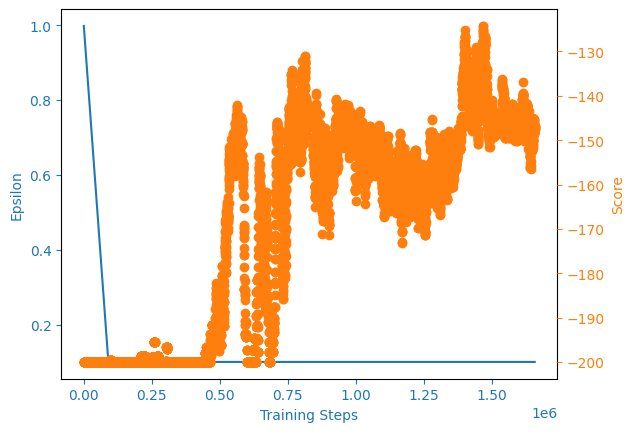

In [ ]:
env = gym.make('MountainCar-v0')
best_score = -np.inf
load_checkpoint = False
n_games = 10  # for DQN and MountainCar-v0, it takes 10000 episodes to train.


agent = DQNAgent(gamma=0.99,
          epsilon=1,
          lr=0.0001,
          input_dims=(env.observation_space.shape),
          fc1_dims=64,
          fc2_dims=64,
          n_actions=env.action_space.n,
          mem_size=50000,
          eps_min=0.1,
          batch_size=32,
          replace=1000,
          eps_dec=1e-5,
          chkpt_dir='models/',
          algo='DQNAgent',
          env_name=env.spec.id)



if load_checkpoint:
    agent.load_models()

fname = agent.algo + '_' + agent.env_name + '_lr' + str(agent.lr) +'_' \
        + str(n_games) + 'games'
figure_file = 'plots/' + fname + '.png'

if not os.path.exists('plots'):
    os.makedirs('plots')


n_steps = 0
scores, eps_history, steps_array = [], [], []

for i in tqdm(range(n_games), desc="Training Progress"):
    done = False
    observation = env.reset()

    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        score += reward

        if not load_checkpoint:
            agent.store_transition(observation, action,
                                  reward, observation_, done)
            agent.learn()
        observation = observation_
        n_steps += 1
    scores.append(score)
    steps_array.append(n_steps)

    avg_score = np.mean(scores[-100:])

    if (i+1) % 20 == 0:
        print('episode: ', i,'score: ', score,
              ' average score %.1f' % avg_score, 'best score %.2f' % best_score,
            'epsilon %.2f' % agent.epsilon, 'steps', n_steps)

    if avg_score > best_score:
        if not load_checkpoint:
            agent.save_models()
        best_score = avg_score

    eps_history.append(agent.epsilon)

x = [i+1 for i in range(len(scores))]
plot_learning_curve(steps_array, scores, eps_history, figure_file)

## Evaluate the learned policy

In [ ]:
env = gym.make('MountainCar-v0')
best_score = -np.inf
load_checkpoint = True
n_games = 100


# Set epsilon=0 for evaluation
agent = DQNAgent(gamma=0.99,
          epsilon=0,
          lr=0.0001,
          input_dims=(env.observation_space.shape),
          fc1_dims=64,
          fc2_dims=64,
          n_actions=env.action_space.n,
          mem_size=50000,
          eps_min=0.1,
          batch_size=32,
          replace=1000,
          eps_dec=1e-5,
          chkpt_dir='models/',
          algo='DQNAgent',
          env_name=env.spec.id)

if load_checkpoint:
    agent.load_models()


n_steps = 0
scores, eps_history, steps_array = [], [], []

for i in range(n_games):
    done = False
    observation = env.reset()

    score = 0
    while not done:
        action = agent.choose_action(observation)
        observation_, reward, done, info = env.step(action)
        # env.render()
        # time.sleep(0.1)
        score += reward

        observation = observation_
        n_steps += 1
    # print(f'episode {i} score {score}')
    scores.append(score)
    steps_array.append(n_steps)

    env.close()


print(np.mean(scores))

-126.16


# Conclusion

1. **DQN integrates deep learning with Q-learning by using a neural network to approximate the Q-value function**. This approach is particularly effective for environments with large or continuous state spaces where tabular methods are impractical.

2. **Experience replay improves learning stability** by storing the agent's experiences and using mini-batches of these experiences for training. This method helps break the correlation between consecutive learning samples and smoothens the learning data over previous experiences, contributing to more stable and effective learning.

3. **Fixed Q-targets address the moving target problem** in traditional Q-learning. By using a separate, periodically updated network to estimate the Q-target values during training, DQNs prevent the rapid shifts in Q-value estimations that can destabilize learning.

4. **DQN achieves better performance with fewer number of training episodes compared to Q-Learning in Mountain Car example.** DQN gets an average episode reward -120 with 10k episodes of training, while Q-Learning with state discretization gets an average episode reward -160 with 50k episodes of training.